# PREPROCESSING

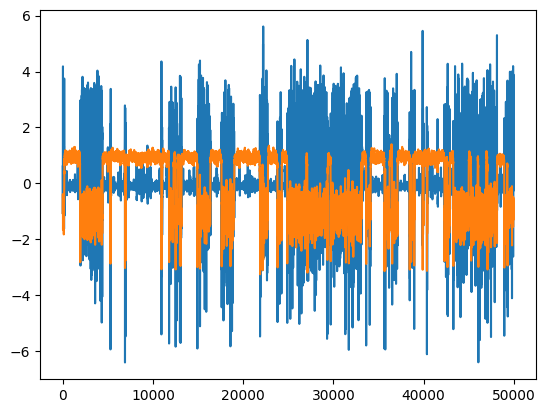

In [2]:
#OS Libraries
import os
import sys

#ML Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.serialization import SourceChangeWarning
from torch.amp import GradScaler, autocast
from torch.nn.parallel import DataParallel

#Functionality Libraries
from tqdm import tqdm
from scipy.integrate import solve_ivp
import random
from scipy.stats import linregress
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import wandb
import datetime
import shutil
import seaborn as sns


psi = np.load(r'/home/danielboscu/Documents/code/AI_RES/data/actual/long_run_310k.npy')
psi = psi[:,1,:]
mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
psi = (psi - mean_psi) / std_psi


# Pre-processing

lead = 1
trainN = 250_000
valN = 50_000
index = 63

# Defining the variable ranges
variable_range = [(0,24), (25, 49), (50, 74), (0, 49), (0,74)]

# Select the variable: 0 for real perturbation, 1 for imaginary perturbation, 2 for zonal winds
variable = 3
num_variables = variable_range[variable][1] - variable_range[variable][0] + 1

# Shuffle and map indices
np.random.seed(42)
valid_indices = np.arange(0, trainN - lead)
shuffled_indices = np.random.permutation(valid_indices)


# Now constrain the shuffled indices to the variable range
np_psi_train_input = psi[shuffled_indices, variable_range[variable][0]:variable_range[variable][1]+1]
np_psi_train_label = psi[shuffled_indices + lead, :]

psi_train_input = torch.tensor(np_psi_train_input)
psi_train_label = torch.tensor(np_psi_train_label)

np_psi_val_input = psi[trainN:trainN+valN, variable_range[variable][0]:variable_range[variable][1]+1]
np_psi_val_label = psi[trainN+lead:trainN+valN+lead, :]
psi_val_input = torch.tensor(np_psi_val_input)
psi_val_label =  torch.tensor(np_psi_val_label)

plt.plot(np_psi_val_input[:,-1]) # Real and Imaginary PSI
plt.plot(np_psi_val_label[:,-1]) # Real and Imaginary PSI + Zonal Wind
plt.show()

In [12]:
# Define the encoder (MLP)
class Encoder(nn.Module):
    def __init__(self, latent_dim, num_neurons):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(75, num_neurons)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_mu = nn.Linear(num_neurons, latent_dim)  # Hidden layer (128) -> Latent space (2)
        self.fc_logvar = nn.Linear(num_neurons, latent_dim)  # Hidden layer (128) -> Log variance (2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        x = torch.relu(self.fc2(x)) + x
        x = torch.relu(self.fc3(x)) + x
        x = torch.relu(self.fc4(x)) + x
        x = torch.relu(self.fc5(x)) + x
        x = torch.relu(self.fc6(x)) + x
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Define the decoder (MLP)
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim, num_neurons):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim, num_neurons)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_output = nn.Linear(num_neurons, output_dim)  # Hidden layer (128) -> Output layer (2)

    def forward(self, z, condition):
        z = torch.cat((z, condition), dim=1)  # Concatenate latent vector and condition
        z = torch.relu(self.fc1(z))  # Activation function for hidden layer
        z = torch.relu(self.fc2(z)) + z
        z = torch.relu(self.fc3(z)) + z
        z = torch.relu(self.fc4(z)) + z
        z = torch.relu(self.fc5(z)) + z
        z = torch.relu(self.fc6(z)) + z
        output = self.fc_output(z)
        return output

# Define the VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim, num_neurons):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(latent_dim, num_neurons)
        self.decoder = Decoder(latent_dim, output_dim, condition_dim, num_neurons)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z, condition):
        return self.decoder(z, condition)

    def forward(self, x, condition):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, condition)
        return output, mu, logvar

output_dim = 75
latent_dim = 32
condition_dim = num_variables
batch_size = 1024

# CHOOSING BY EXP FIT

In [4]:
# CHOOSING BY EXP FIT
# TO-DO: Check if crps is correct

from scipy.stats import linregress

def normalize_transition_time(s, neuro_num, r):
    """
    Normalize the transition time based on the specified num_neurons and reference value.

    Args:
        s (float): The transition time to normalize.
        neuro_num (float): The num_neurons value for normalization.
        r (float): The reference value for normalization.

    Returns:
        norm (float): The normalized transition time.
    """
    norm = 1 - np.exp(-np.abs((s - r)) / neuro_num)
    return norm

# Code from Ira Shokar but slightly changed
def crps_score(p, y):
    """
    Calculate CRPS for given predictions and observations.

    Args:
        p (Tensor): Predictions, shape (N, D) where N = ens_num and D is the dimension of the prediction.
        y (Tensor): Observations, shape (D) where D is the dimension of the observation.

    Returns:
        crps (float): The CRPS score.
    """
    y  = y.unsqueeze(0)
    # First term: mean distance from observations to ensemble members
    mae     = torch.cdist(y, p, 1).mean()
    # Second term: mean distance between ensemble members (properly normalized)
    ens_var = torch.cdist(p, p, 1).mean()
    
    return mae - 0.5 * ens_var

# Function to calculate transition durations
def calculate_transition_durations(y, u, l):
    """
    Calculate the return periods with user-defined upper and lower bounds.

    Args:
        y (np.array): The time series data.
        u (float): The upper bound for the transition.
        l (float): The lower bound for the transition.

    Returns:
        t_times (list): The list of return periods for transitions.
    """

    t_times = []
    s = None
    above_u = False
    below_l = False
    for i in range(1, len(y)):
        if y[i] < l:  
            below_l = True
            above_u = False
        elif y[i] > u:  
            if below_l and s is not None:
                t_times.append(i - s)
                s = None  
            above_u = True
            below_l = False

        if below_l and s is None:
            s = i
    return t_times

def KL_coefficient(r, p, num_neurons, cycle, KL_by_dim_cycle, L1_by_dym_cycle):
    """
    Calculate the KL divergence between two distributions and normalize it.

    Args:
        r (np.array): Real distribution.
        p (np.array): Predicted distribution.
        num_neurons (float): num_neurons value for normalization.
        cycle (int): Cycle number for tracking.
        KL_by_dim_cycle (dict): Dictionary to store KL divergence values by dimension and cycle.

    Returns:
        r (np.array): Processed real distribution.
        p (np.array): Processed predicted distribution.
        nkl (float): Normalized KL divergence.
    """
    # Calculating KL divergence
    r = r[:300000, 1, 63]
    p = p[:300000]
    
    rh, b = np.histogram(r, bins=100, density=True)
    ph, _ = np.histogram(p, bins=b, density=True)

    abs_diff = np.abs(rh-ph)
    max_diff = np.max(abs_diff)
    norm_diff = max_diff / (np.max(rh) + np.max(ph))

    e = 1e-10
    rh += e
    ph += e

    # Calculate KL divergence between the two histograms
    kl = np.sum(rh * np.log(rh / ph))
    nkl = normalize_transition_time(kl, 1, 0)

    KL_by_dim_cycle[num_neurons][cycle].append(nkl)
    L1_by_dym_cycle[num_neurons][cycle].append(norm_diff)
    
    return r, p, nkl, norm_diff

def CCDF_fit(p_times, s):
    """
    Calculate the slope of the CCDF of transition times and normalize it.

    Args:
        p_times (list): Transition times from predictions.
        s (float): Real value for normalization.
    
    Returns:
        np_slope (float): Normalized slope of the CCDF.
    """
    # === PREDICTIONS CCDF AND FIT ===
    if len(p_times) > 0 and len(np.unique(p_times)) > 1:
        sp_times = np.sort(p_times)
        p_ccdf = 1 - np.arange(1, len(sp_times) + 1) / len(sp_times)

        p_v_indices = p_ccdf > 0
        px_fit = sp_times[p_v_indices]
        py_fit = np.log(p_ccdf[p_v_indices])

        p_slope, _, *_ = linregress(px_fit, py_fit)
        np_slope = normalize_transition_time(p_slope, 0.005, s)
        return np_slope

    else:
        print("No transitions detected in predictions for CCDF slope evaluation.")

def Mean_and_std_of_predictions(p_times, r_times, neuro_num, cc, transitions_by_dim_cycle, transitions_normalized_by_dim_cycle, transitions_normalized_std_by_dim_cycle):
    """
    Calculate the mean and standard deviation of transition times from predictions and normalize them.

    Args:
        p_times (list): Transition times from predictions.
        r_times (list): Transition times from real data.
        neuro_num (float): num_neurons value for normalization.
        cc (int): Cycle number for tracking.
        transitions_by_dim_cycle (dict): Dictionary to store transition times by dimension and cycle.
        transitions_normalized_by_dim_cycle (dict): Dictionary to store normalized transition times by dimension and cycle.
        transitions_normalized_std_by_dim_cycle (dict): Dictionary to store normalized standard deviations by dimension and cycle.

    Returns:
        npd_mean (float): Normalized mean of transition times.
        npd_std (float): Normalized standard deviation of transition times.
    """
    p_mean = np.mean(p_times)
    p_std = np.std(p_times)

    pd_mean = abs(p_mean - np.mean(r_times))
    pd_std = abs(p_std - np.std(r_times))

    npd_mean = normalize_transition_time(pd_mean, 1000, np.mean(r_times))
    npd_std = normalize_transition_time(pd_std, 1000, np.std(r_times))

    npd_std = 1 if npd_std == 0 else npd_std

    transitions_by_dim_cycle[neuro_num][cc].append(pd_mean)
    transitions_normalized_by_dim_cycle[neuro_num][cc].append(npd_mean)
    transitions_normalized_std_by_dim_cycle[neuro_num][cc].append(npd_std)

    return npd_mean, npd_std

# KL Annealing (FROM PAPER)
def frange_cycle_linear(start, stop, n_epoch, n_cycle=4, ratio=0.5):
    """
    Generate a linear schedule for KL annealing over multiple cycles.

    Args:
        start (float): Starting value of the schedule.
        stop (float): Stopping value of the schedule.
        n_epoch (int): Total number of epochs.
        n_cycle (int): Number of cycles for the schedule.
        ratio (float): Ratio of the cycle length to the total number of epochs.

    Returns:
        L (np.array): Array containing the linear schedule values for each epoch.
    """
    L = np.ones(n_epoch)
    period = n_epoch/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):

        v , i = start , 0
        while v <=stop and (int(i+c*period) < n_epoch):
            L[int(i+c*period)] = v
            v += step
            i += 1
    return L
from matplotlib import gridspec
import seaborn as sns
import os

def Timeseries_plot(y, p, ax):
    """
    Plot the timeseries.

    Args:
        y (np.array): Actual zonal wind values.
        p (np.array): Predicted zonal wind values.
        ep (int): Current epoch number.
        ax (matplotlib.axes.Axes): Axes object to plot on.

    Returns:
        None. Just plots the timeseries on the provided axes.
    """
    ax.plot(y, 'b', label='Actual')
    ax.plot(p, 'r', label='Predictions')

    ax.set_title(f"Timeseries of Zonal Winds at Level 14th of the Atmosphere", fontsize=16)
    ax.set_xlabel('Time Step', fontsize=14)
    ax.set_ylabel('Zonal Wind Value', fontsize=14)

    ax.legend(['Predictions', 'Actual'])
    ax.grid(True)

    # save_path = os.path.join(folder, "timeseries")
    # save_path = os.path.join(save_path, f"timeseries_plot_{epoch+1}.png")

    # plt.savefig(save_path)

    # plt.show()75

def PDF_plot(y, p, pdf_dt, ax):
    """
    Plot PDFs of the zonal wind values.

    Args:
        y (np.array): Actual zonal wind values.
        p (np.array): Predicted zonal wind values.
        ep (int): Current epoch number.
        pdf_dt (float): KL diff between the PDFs of actual and predicted values.
        ax (matplotlib.axes.Axes): Axes object to plot on.

    Returns:
        None. Just plots the PDFs on the provided axes.
    """

    sns.histplot(y, bins=100, kde=True, color='black', alpha=0.6, element='step', label='Real Data', ax=ax)
    sns.histplot(p, bins=100, kde=True, color='red', alpha=0.6, element='step', label='Predictions', ax=ax)

    ax.set_title(f"Probability Distribution Functions (PDFs) | KL Error: {pdf_dt:.4f}", fontsize=16)
    ax.set_xlabel('Zonal Wind (m/s)', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    
    ax.axvline(np.mean(y), color='black', linestyle='--', label=f'Real Mean: {np.mean(y):.2f}')
    ax.axvline(np.mean(p), color='red', linestyle='--', label=f'Pred Mean: {np.mean(p):.2f}')

    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)

    # save_path = os.path.join(folder, "bi_modal_distri")
    # save_path = os.path.join(save_path, f"bi_modal_distribution_plot_{epoch+1}.png")
    # plt.savefig(save_path)

    # plt.show()

def Exp_fit_plot(xlp, yvp, xlr, yvr, p_exp_fit, r_exp_fit, exp_d, range_d, ax):
    """
    Plot the exponential fits of transition return periods.

    Args:
        xlp (np.array): X values for predicted exponential fit.
        yvp (np.array): Y values for predicted exponential fit.
        xlr (np.array): X values for real exponential fit.
        yvr (np.array): Y values for real exponential fit.
        p_exp_fit (float): Slope of the predicted exponential fit.
        r_exp_fit (float): Slope of the real exponential fit.
        ep (int): Current epoch number.
        exp_d (float): Exponential fit error for predictions.
        range_d (float): Range error for predictions.
        ax (matplotlib.axes.Axes): Axes object to plot on.

    Returns:
        None. Just plots the exponential fits on the provided axes.
    """
    ax.plot(xlp, yvp, 'r-', label=f'Pred Exp Fit (slope={p_exp_fit:.4f})', linewidth=2)
    ax.plot(xlr, yvr, 'b-', label=f'Real Exp Fit (slope={r_exp_fit:.4f})', linewidth=2)

    ax.set_xlabel('Time Duration (Steps)')
    ax.set_ylabel('Exponential Fit')
    ax.set_title(f"Exponential Fits of Transition Return Periods | Exp Error: {exp_d:.4f} | Range Error: {range_d:.4f}", fontsize=16)
   
    ax.set_yscale("linear")  # y-axis log scale
    ax.set_xscale("linear")  # x-axis linear scale
    
    ax.grid()
    ax.legend()
    
    # save_path = os.path.join(folder, "expo_fit")
    # save_path = os.path.join(save_path, f"expo_fit_plot_{epoch}.png")
    # plt.savefig(save_path)
    # plt.show()

def Final_KL_PDF_plot(KL_by_dim_cycle, r, neuro_num, ncc, f):
    """
    Plot the average transition values across all cycles.

    Args:
        KL_by_dim_cycle (dict): Dictionary containing KL PDF values by dimension and cycle.
        r (float): Real data value for comparison.
        neuro_num (float): num_neurons coefficient for normalization.
        ncc (int): Number of cycles.
        f (str): Folder path to save the plot.
    
    Returns:
        None. Just plots the average transition values and saves the figure.
    """
    plt.figure(figsize=(10, 6))
    for c in range(ncc):
        plt.plot(KL_by_dim_cycle[neuro_num][c], 'o-', label=f'Cycle {c}')
    
    plt.xlabel('Epoch within Cycle')
    plt.ylabel('KL Difference Normalized')
    plt.ylim(0,1)
    plt.title(f'KL Difference Value between PDFs Normalized)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    f = os.path.join(f, f"KL_diff_all_cycles.png")
    plt.savefig(f)
    plt.close()


def Final_exp_fit_plot(exp_fit_by_dim_cycle, r_exp_fit, neuro_num, ncc, f):
    """
    Plot the exponential fit values across all cycles.

    Args:
        exp_fit_by_dim_cycle (dict): Dictionary containing exponential fit values by dimension and cycle.
        r_exp_fit (float): Real data value for comparison.
        neuro_num (float): num_neurons coefficient for normalization.
        ncc (int): Number of cycles.
        f (str): Folder path to save the plot.

    Returns:
        None. Just plots the exponential fit values and saves the figure.
    """
    plt.figure(figsize=(10, 6))
    for c in range(ncc):
        plt.plot(exp_fit_by_dim_cycle[neuro_num][c], 'o-', label=f'Cycle {c}')
    
    plt.axhline(y=r_exp_fit, color='r', linestyle='--', label='Real Data')

    plt.xlabel('Epoch within Cycle')
    plt.ylabel('Exponential Fit Value')
    plt.title(f'Exponential Fit Progress (num_neurons Coefficient={neuro_num})')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()

    f = os.path.join(f, f"exponential_fit_plot_all_cycles.png")
    plt.savefig(f)
    plt.close()
    
def all_plot(y, p, xlp, yvp, xlr, yvr, 
             p_exp_fit, r_exp_fit, pdf_dt, exp_dt, range_dt, folder):
    """
    Comprehensive plot with timeseries, PDF, and exponential fit.

    Args:
        y (np.array): Actual zonal wind values.
        p (np.array): Predicted zonal wind values.
        xlp (np.array): X values for predicted exponential fit.
        yvp (np.array): Y values for predicted exponential fit.
        xlr (np.array): X values for real exponential fit.
        yvr (np.array): Y values for real exponential fit.
        p_exp_fit (float): Slope of the predicted exponential fit.
        r_exp_fit (float): Slope of the real exponential fit.
        pdf_dt (float): KL divergence between the PDFs of actual and predicted values.
        exp_dt (float): Exponential fit error for predictions.
        range_dt (float): Range error for predictions.
        ep (int): Current epoch number.
        folder (str): Folder path to save the plot.
    
    Returns:
        None. Just plots the timeseries, PDF, and exponential fit and saves the figure.
    """
    fig = plt.figure(figsize=(24, 10))
    gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1,1], height_ratios=[1,1])

    ax_timmeseries = fig.add_subplot(gs[:, 0])
    ax_pdf = fig.add_subplot(gs[0, 1])
    ax_exp_fit = fig.add_subplot(gs[1, 1])

    Timeseries_plot(y[:60000], p[:60000], ax_timmeseries)
    PDF_plot(y, p, pdf_dt, ax_pdf)
    Exp_fit_plot(xlp, yvp, xlr, yvr, 
                 p_exp_fit, r_exp_fit, exp_dt, range_dt, ax_exp_fit)
    
    dt = np.sqrt(pdf_dt**2 + exp_dt**2 + range_dt**2)
    fig.suptitle(f"Predictions vs Actual | Euclidean Metric Error: {dt}", fontsize=20)
    plt.subplots_adjust(wspace=0.2, hspace=0.35)  # Adjust these values as desired
    fig.tight_layout(pad=2.0)
    plt.savefig(os.path.join(folder, f"all_plots.png"))
    plt.show()

def Loss_plot(t_loss, v_loss, cc, neuro_num, f):
    """
    Plot the training and validation losses.

    Args:
        t_loss (list): Training loss values.
        v_loss (list): Validation loss values.
        cc (int): Cycle number for tracking.
        neuro_num (float): num_neurons value for normalization.
        f (str): Folder path to save the plot.
    
    Returns:
        None. Just plots the training and validation losses and saves the figure.
    """
    plt.figure(figsize=(10,6))

    plt.plot(t_loss, label='Training Loss')
    plt.plot(v_loss, label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Losses for Cycle {cc+1} with num_neurons {neuro_num}')
    plt.legend()

    f = os.path.join(f, f"loss_plot_cycle_{cc+1}_num_neurons_{neuro_num}.png")
    plt.savefig(f)
    plt.close()
    
# TO-DO: Try to change KL metric to KS. Add all graphs in one figure and add the distance metric to the best model selection to it.

# Training

torch.cuda.empty_cache()

import datetime
import os
import shutil
from scipy.stats import linregress
import seaborn as sns
from matplotlib.gridspec import GridSpec

def model_restore(mp, model):
    """
    Restore the model state from a saved checkpoint.

    Args:
        mp (str): Path to the model checkpoint.
        model (nn.Module): The model to restore.

    Returns:
        None. The model state is loaded from the checkpoint if it exists.
    """
    if os.path.exists(mp):
        print(f"Loading model from {mp}")
        model.load_state_dict(torch.load(mp))

def inference(model, psi, tst, vr, v, nv, ld):
    """
    Perform inference using the trained model.

    Args:
        model (nn.Module): The trained model.
        psi (np.array): Input data for inference.
        tst (int): Number of time steps.
        vr (dict): Variable ranges for the input data.
        v (int): Index of the variable to use for inference.
        nv (int): Number of variables.
        ld (int): Latent dimension of the model.
    
    Returns:
        p (np.array): Predictions made by the model.
    """
    s, e = vr[v][0], vr[v][1]+1
    init_c = torch.reshape(torch.tensor(psi[0,s:e]), [1, nv])
    z = torch.zeros([1,ld])
    p = np.zeros ([tst, 75])

    for k in range (0, tst):

        with torch.inference_mode():
            model.eval()

            with autocast(device_type='cuda'):

                if (k ==0):

                    z = torch.randn_like(z).float().cuda(non_blocking=True)
                    init_c = init_c.float().cuda(non_blocking=True)

                    y = (model.decode(z, init_c)).detach().cpu().numpy()
                    p[k,:] = y

                    init_c = torch.tensor(y[:, s:e])

                else:
                    z = torch.randn_like(z).float().cuda(non_blocking=True)
                    init_c = torch.reshape(torch.tensor(p[k-1,s:e]),[1,nv]).float().cuda(non_blocking=True)

                    y = (model.decode(z,init_c)).detach().cpu().numpy()
                    p[k,:] = y

                    init_c = torch.tensor(y[:, s:e])
    
    return p

def euclidean_distance_for_predictions(ms):
    """
    Calculate the Euclidean distance for a list of metrics.

    Args:
        ms (list): List of computed metrics.

    Returns:
        dt (float): The Euclidean distance calculated from the given computed metrics.
    """
    s = 0
    for m in ms:
        s += m ** 2
    dt = np.sqrt(s)
    return dt

def save_best_cycle_epoch(models, neuro_num, cc, ep, f,
                          exp_fit_normalized_by_dim_cycle, 
                          KL_by_dim_cycle, duration_diff_by_dim_cycle, 
                          best_models_saved, best_models):
    """
    Select the best model from a cycle based on combined distance metrics and save it.

    Args:
        models (list): List of model paths for the current cycle.
        neuro_num (float): num_neurons coefficient for normalization.
        cc (int): Current cycle number.
        ep (int): Current epoch number.
        f (str): Folder path to save the best model.
        exp_fit_normalized_by_dim_cycle (dict): Dictionary containing normalized exponential fit values by dimension and cycle.
        KL_by_dim_cycle (dict): Dictionary containing KL divergence values by dimension and cycle.
        duration_diff_by_dim_cycle (dict): Dictionary containing range differences by dimension and cycle.
        best_models_saved (list): List to store the paths of the best models saved.
        best_models (list): List to store the best models selected.

    Returns:
        None. The best model is saved to the specified folder.
    """
    
    b_model = None
    b_i = -1
    b_dt = float('inf')

    for i in range(len(models)):  # models contains each epoch's model in the current cycle
        print(exp_fit_normalized_by_dim_cycle[neuro_num][cc][i])
        print(KL_by_dim_cycle[neuro_num][cc][i])
        print(duration_diff_by_dim_cycle[neuro_num][cc][i])
        ms = [exp_fit_normalized_by_dim_cycle[neuro_num][cc][i],
                   KL_by_dim_cycle[neuro_num][cc][i], 
                   duration_diff_by_dim_cycle[neuro_num][cc][i]]
        
        dt = euclidean_distance_for_predictions(ms)
        if dt < b_dt:
            b_dt = dt
            b_i = i
            b_model = models[i]

    if b_i != -1:
        best_models_saved.append(b_model)
        best_models.append((cc, b_i))

    shutil.copyfile(models[b_i], f"{f}/best_model_combined_distance_at_cycle_{cc}_and_checkpoint_{ep}.pth")
    print(f"New best model saved with distance {dt:.4f} at epoch {i+1}")

def save_best_epoch(best_models, best_models_saved, exp_fit_normalized_by_dim_cycle,
                    KL_by_dim_cycle, duration_diff_by_dim_cycle, neuro_num, mf):
    
    """
    Select the best model from the master training run based on combined distance metrics and save it.

    Args:
        models (list): List of model paths for the current cycle.
        neuro_num (float): num_neurons coefficient for normalization.
        cc (int): Current cycle number.
        ep (int): Current epoch number.
        f (str): Folder path to save the best model.
        exp_fit_normalized_by_dim_cycle (dict): Dictionary containing normalized exponential fit values by dimension and cycle.
        KL_by_dim_cycle (dict): Dictionary containing KL divergence values by dimension and cycle.
        duration_diff_by_dim_cycle (dict): Dictionary containing range differences by dimension and cycle.
        best_models_saved (list): List to store the paths of the best models saved.
        best_models (list): List to store the best models selected.

    Returns:
        None. The best model is saved to the specified folder.
    """

    print("Selecting the best model based on combined distance...")

    # Ensure best_models is not empty
    if not best_models:
        print("No best models found.")
        return
    
    # After all cycles - final best model selection
    b_model = None
    w_model = (-1, -1)
    b_model_dt = float('inf')

    print(f"Number of best models saved: {len(best_models)}")
    for idx, (cc, ep_idx) in enumerate(best_models):

        ms = [exp_fit_normalized_by_dim_cycle[neuro_num][cc][ep_idx], 
                   KL_by_dim_cycle[neuro_num][cc][ep_idx], 
                   duration_diff_by_dim_cycle[neuro_num][cc][ep_idx]]
        
        dt = euclidean_distance_for_predictions(ms)        
        print(f"Distance for model from cycle {cc+1}, epoch {ep_idx+1}: {dt:.4f}")
        print(f"Current best distance: {b_model_dt:.4f}")
        
        if dt < b_model_dt:
            b_model_dt = dt
            b_model = best_models_saved[idx]
            w_model = (cc, ep_idx)

    # Save the best model  
    i,n = w_model
    cc = i
    ep = n

    if cc == -1:
        print("No best model found.")
    else:
        shutil.copyfile(b_model, f"{mf}/best_{neuro_num}_neurons_model_with_emr_{b_model_dt:.4f}_at_epoch_{ep+1}.pth")
        print(f"Best model saved with cycle {cc+1} and epoch {ep+1}.")

# INFERENCE

Number of neurons: 512, Latent dimension: 32, Output dimension: 75, Condition dimension: 50
Variable range for 3: 0 to 50
Model weights loaded from /home/danielboscu/Documents/code/AI_RES/training/best/foundation.pth
Reference Real Data average_transition_time: 759.8341708542714
Reference Real Data CCDF Slope: -0.0013499649649256768
(300000, 75) (309700, 2, 75)
[(0, 24), (25, 49), (50, 74), (0, 49), (0, 74)] 3 50 32


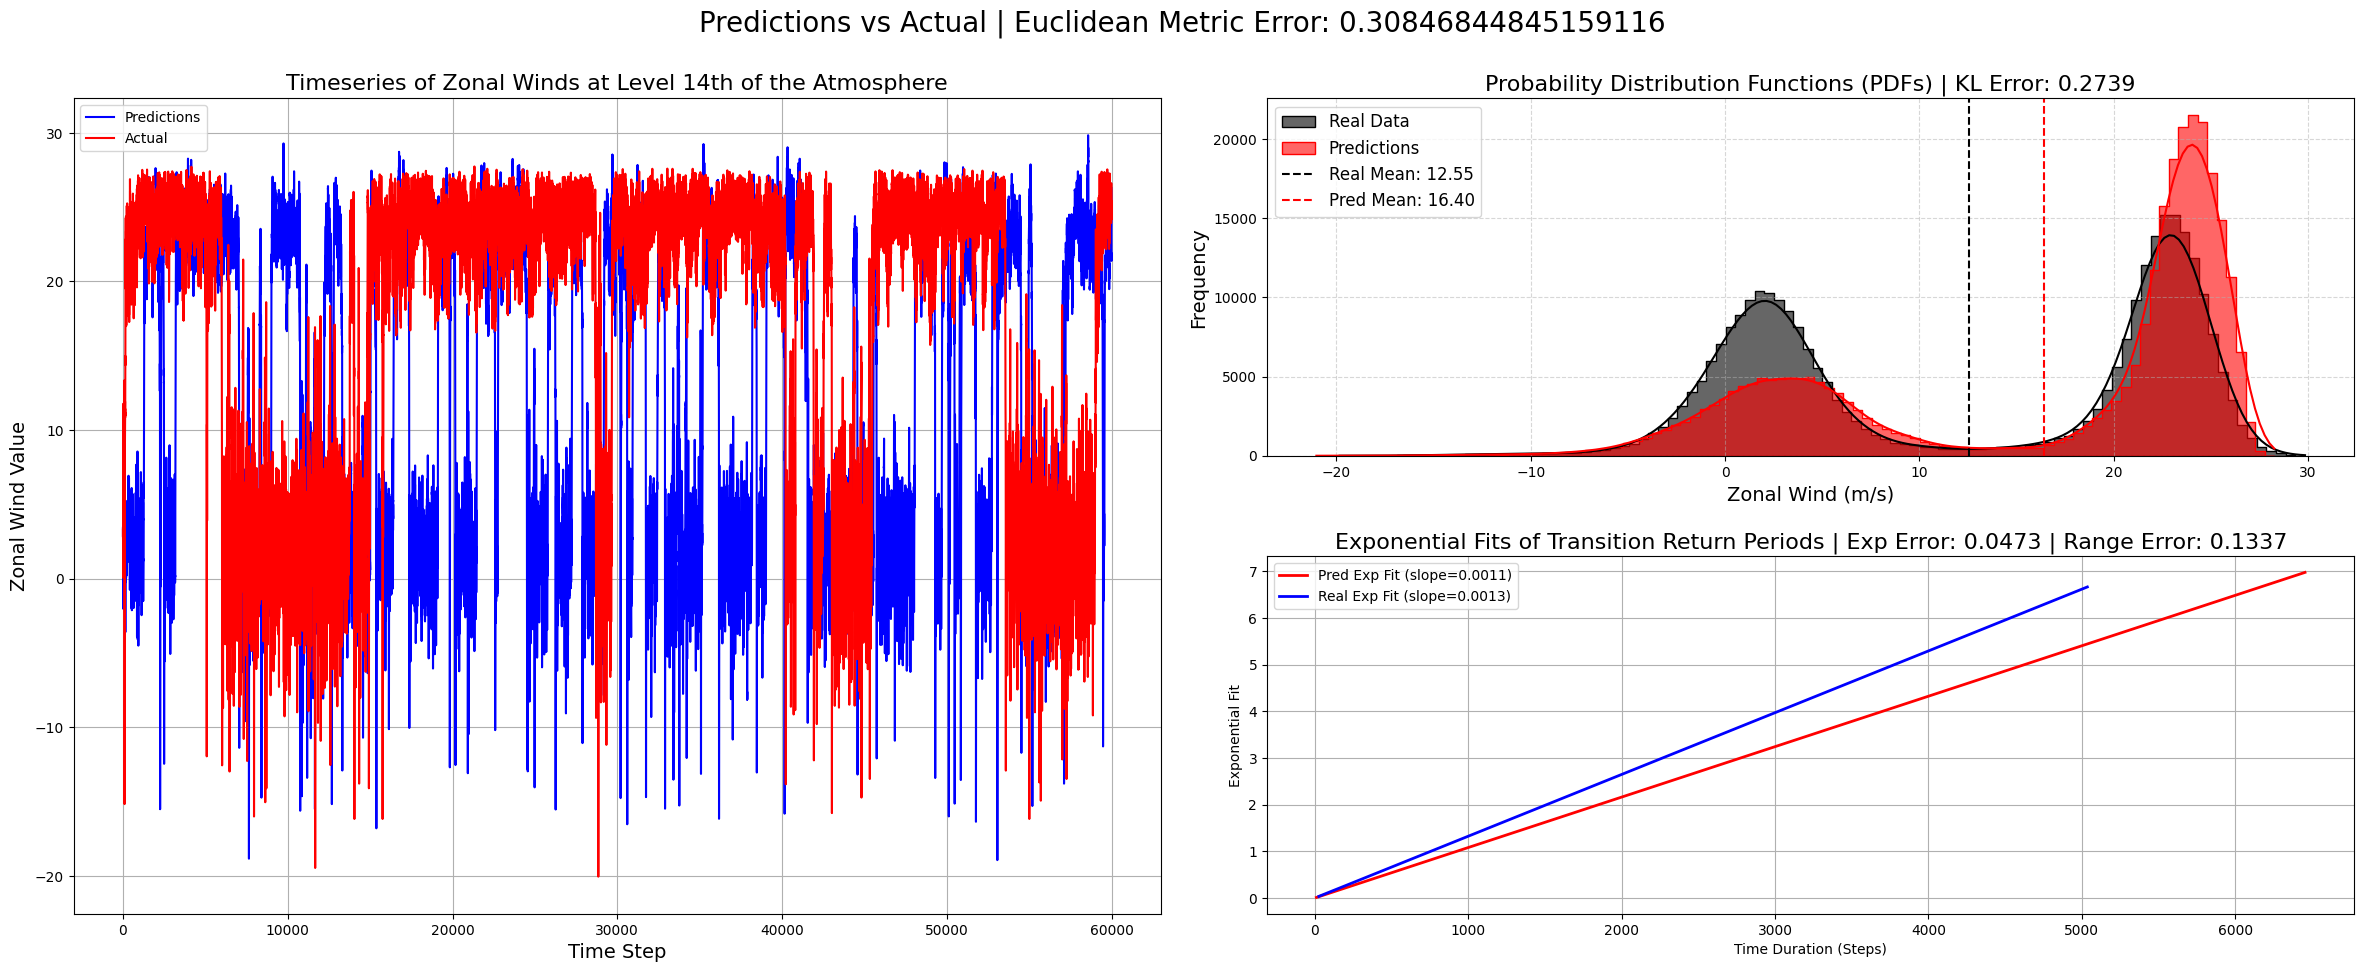

In [ ]:
from sklearn.metrics import mean_squared_error

# Initialization
time_step       = 300_000
real_data       = np.load(r'/home/danielboscu/Documents/code/AI_RES/data/actual/long_run_310k.npy')
level           = 63
upper_bound     = 53.8 / 2.8935
lower_bound     = 7.41
real_data_1d    = real_data[:, 1, level]

num_neurons     = 1024
latent_dim      = 32
output_dim      = 75
condition_dim   = num_variables

print(f"Number of neurons: {num_neurons}, Latent dimension: {latent_dim}, Output dimension: {output_dim}, Condition dimension: {condition_dim}")
model = ConditionalVAE(latent_dim, output_dim, condition_dim, num_neurons)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
start, end = variable_range[variable][0], variable_range[variable][1]+1
print(f"Variable range for {variable}: {start} to {end}")

folder = "/home/danielboscu/Documents/code/AI_RES/training"
model_weights_path = r'/home/danielboscu/Documents/code/AI_RES/training/RCVAE_model_at_2025-07-17 15:00:00.240341/best_1024_neurons_model_with_emr_0.1378_at_epoch_105.pth'
past_model = True

if past_model:
    if os.path.exists(model_weights_path):
        model.load_state_dict(torch.load(model_weights_path))
        print(f"Model weights loaded from {model_weights_path}")

real_durations      = calculate_transition_durations(real_data_1d, upper_bound, lower_bound)
real_data_sorted    = np.sort(real_durations)
transition_real     = np.mean(real_data_sorted)

actual_hist, bin_edges = np.histogram(real_data[:, 1, level], bins=50, density=True)
print(f"Reference Real Data average_transition_time: {transition_real}")

# Compute CCDF slope for real data
ccdf_real           = 1 - np.arange(1, len(real_data_sorted) + 1) / len(real_data_sorted)
valid_indices_real  = ccdf_real > 0
x_fit_real          = real_data_sorted[valid_indices_real]
y_fit_real          = np.log(ccdf_real[valid_indices_real])
slope_real, intercept_real, *_ = linregress(x_fit_real, y_fit_real)
print(f"Reference Real Data CCDF Slope: {slope_real}")

# Compute exponential fit for real data
x_line_real = np.linspace(min(real_data_sorted), max(real_data_sorted), 100)
exponential_fit_real = 1/np.mean(real_data_sorted)
y_values_real = exponential_fit_real*x_line_real

pred = inference(model, psi, time_step, variable_range, variable, 
                             condition_dim, latent_dim)

print(pred.shape, real_data.shape)
print(variable_range, variable, condition_dim, latent_dim)

# Denormalize final preds
pred_mean = pred[:time_step, :] * std_psi[:, :] + mean_psi[:, :]
r = real_data[:300000, 1, level]
p = pred_mean[:, 63]

# Compute transition durations for real data
real_durations = calculate_transition_durations(r, upper_bound, lower_bound)

# Compute transition durations for predictions data
pred_durations = calculate_transition_durations(p, upper_bound, lower_bound)

exp_fit_p = 1

# === REAL DATA CCDF AND FIT ===
if len(real_durations) == 0:
    print("No transitions detected in real data with current bounds!")
else:
    real_data_sorted = np.sort(real_durations)
    xlr = np.linspace(min(real_data_sorted), max(real_data_sorted), 100)
    exp_fit_r = 1/np.mean(real_data_sorted)
    yvr = exp_fit_r*xlr

# === PREDICTIONS CCDF AND FIT ===
if len(pred_durations) == 0:
    print("No transitions detected in predictions with current bounds!")
else:
    pred_data_sorted = np.sort(pred_durations)
    xlp = np.linspace(min(pred_data_sorted), max(pred_data_sorted), 100)
    exp_fit_p = 1/np.mean(pred_data_sorted)
    yvp = exp_fit_p*xlp

exp_fit_d = normalize_transition_time(exp_fit_p, 0.005, exp_fit_r)

max_pred = np.max(pred_durations)
min_pred = np.min(pred_durations)
difference = abs(max_pred - min_pred)
dur_diff_n = normalize_transition_time(difference, 10000, abs(np.max(real_durations)-np.min(real_durations)))

rh, b = np.histogram(r, bins=100, density=True)
ph, _ = np.histogram(p, bins=b, density=True)

e = 1e-10
rh += e
ph += e

# Calculate KL divergence between the two histograms
kl = np.sum(rh * np.log(rh / ph))
nkl = normalize_transition_time(kl, 1, 0)

save_path = os.path.join(folder, "timeseries")

all_plot(r, p, xlp, yvp, xlr, yvr, exp_fit_p, exp_fit_r, nkl, exp_fit_d, dur_diff_n, folder)


# Single Time Step RMSE Analysis

Number of neurons: 1024, Latent dimension: 32, Output dimension: 75, Condition dimension: 50
Variable range for 3: 0 to 50
Model weights loaded from /home/danielboscu/Documents/code/AI_RES/training/RCVAE_model_at_2025-07-17 15:00:00.240341/best_1024_neurons_model_with_emr_0.1378_at_epoch_105.pth


Single Step Predictions: 100%|██████████| 30000/30000 [00:12<00:00, 2363.12it/s]


(30000, 75)


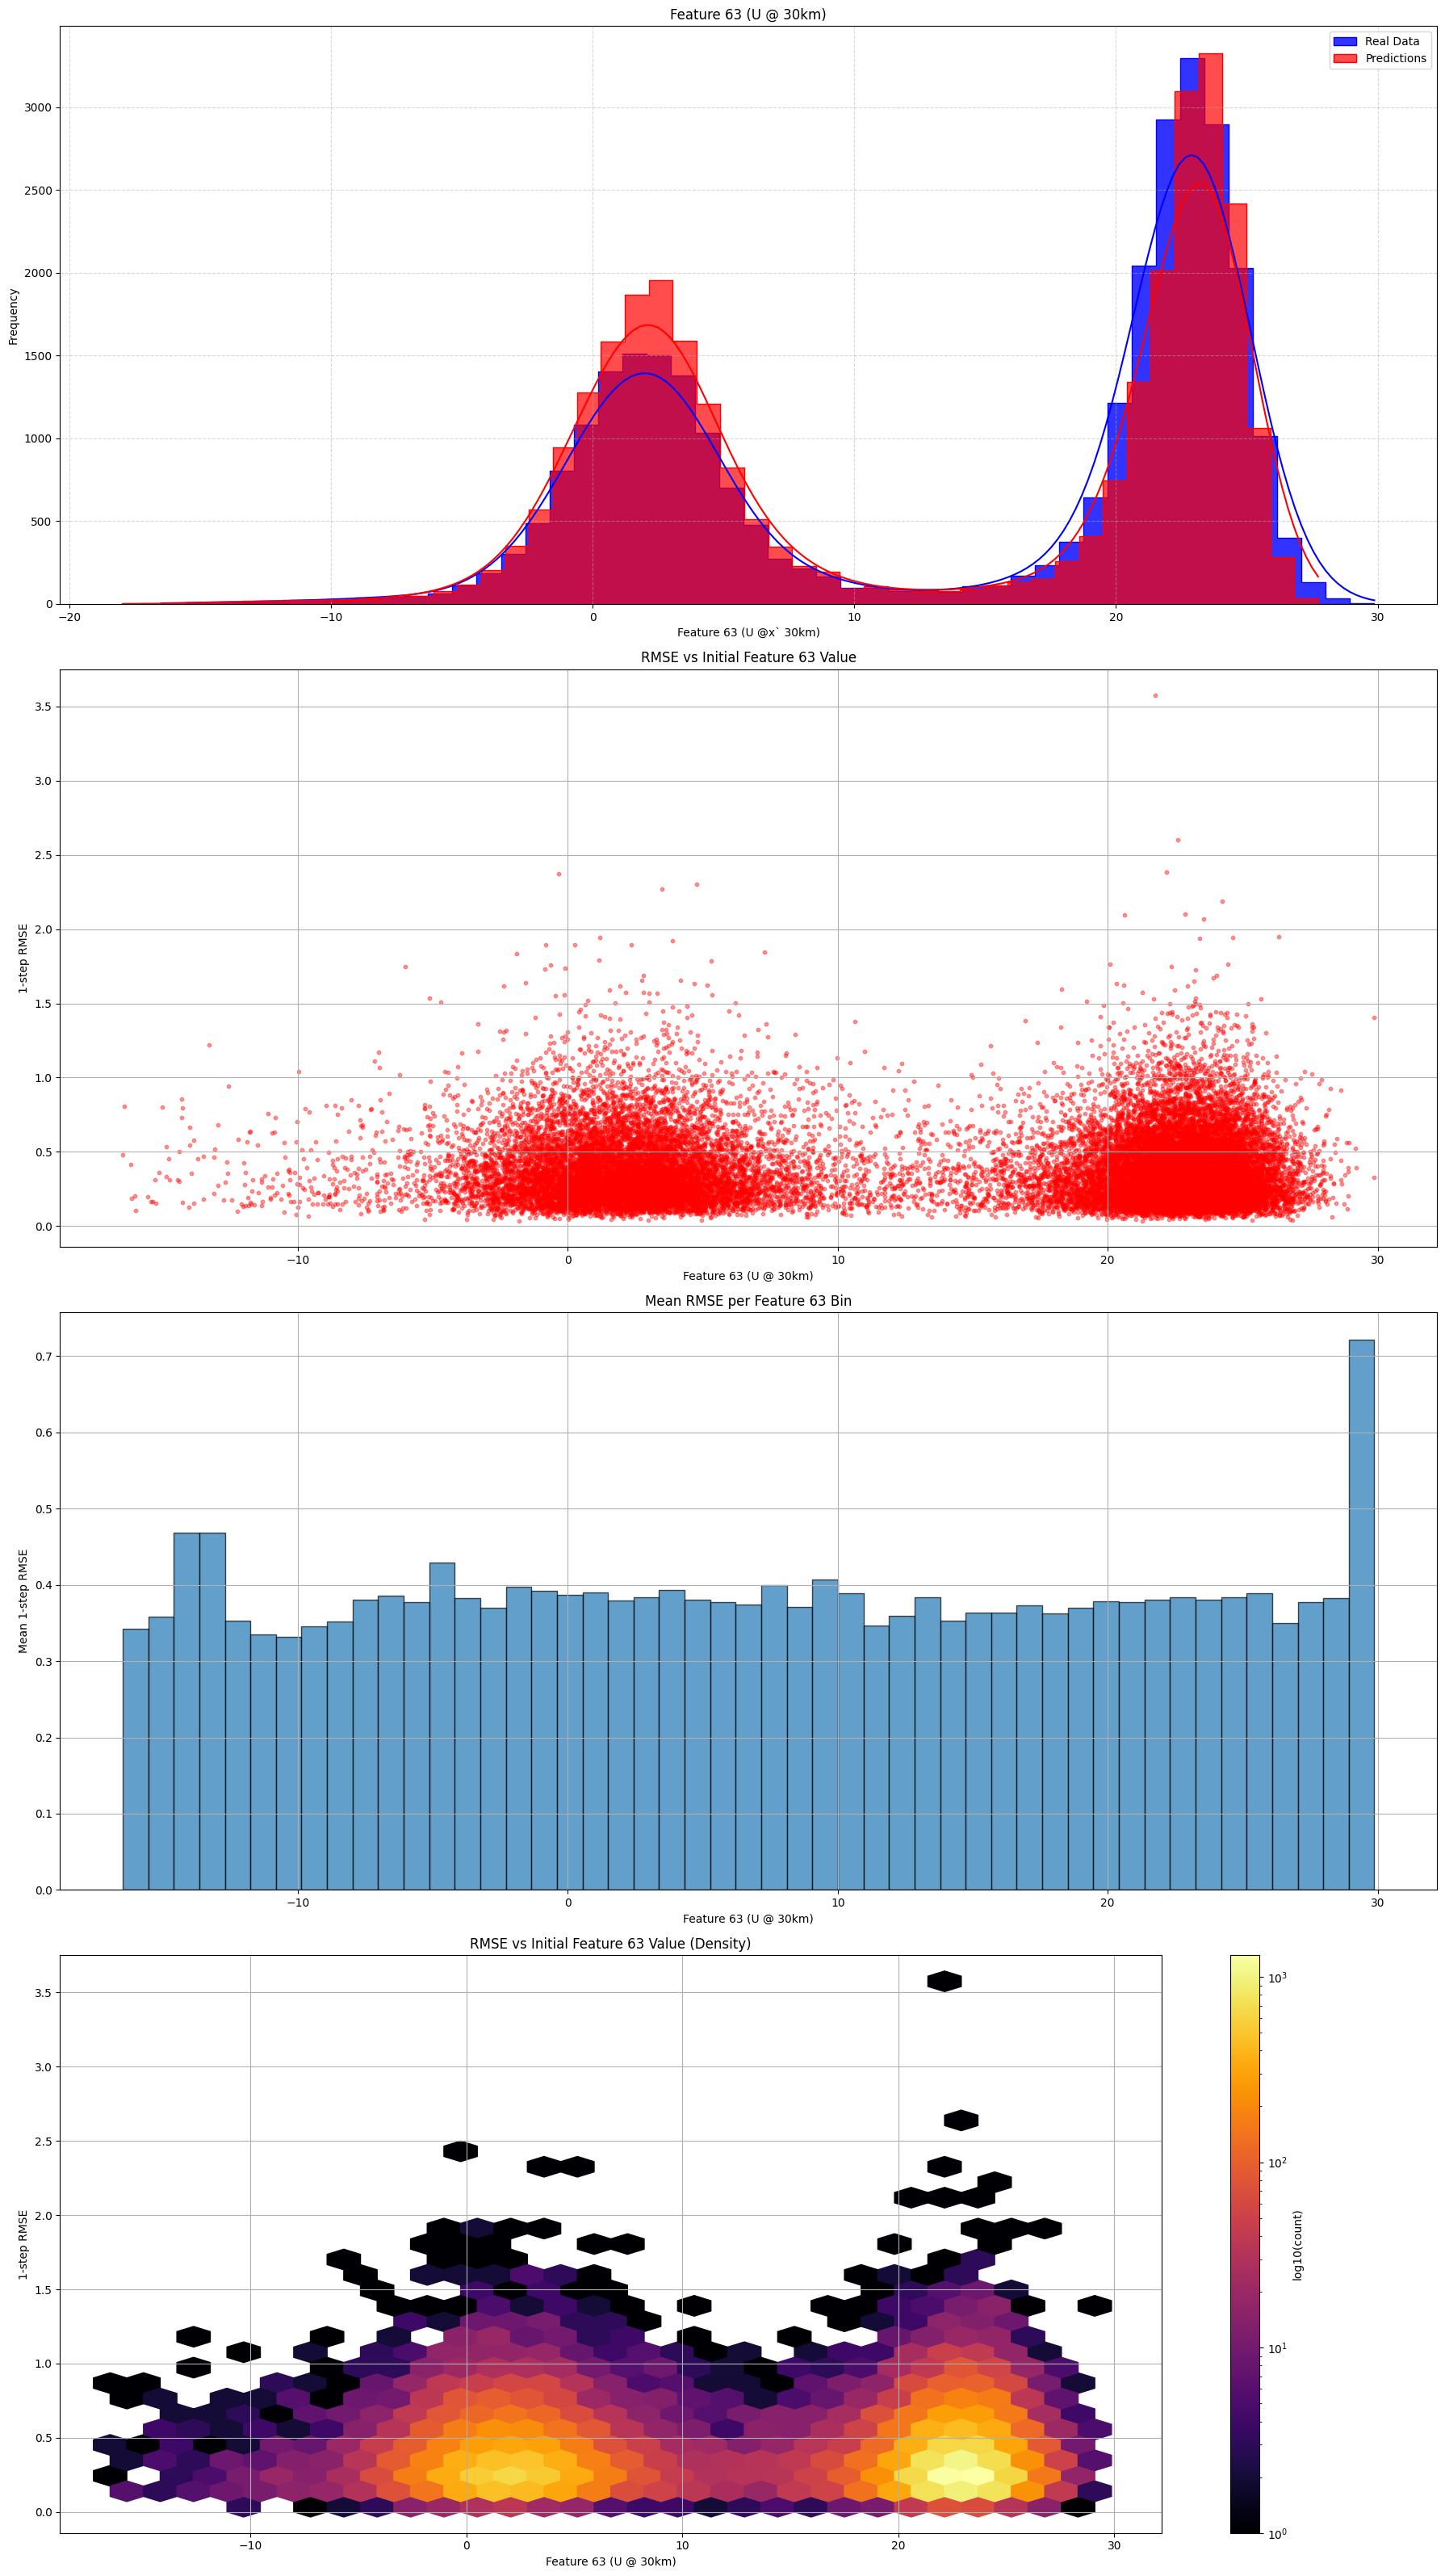

In [13]:
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Initialization
time_step       = 300_000
real_data       = np.load(r'/home/danielboscu/Documents/code/AI_RES/data/actual/long_run_310k.npy')
level           = 63
upper_bound     = 53.8 / 2.8935
lower_bound     = 7.41
real_data_1d    = real_data[:, 1, level]

num_neurons     = 1024
latent_dim      = 32
output_dim      = 75
condition_dim   = num_variables

print(f"Number of neurons: {num_neurons}, Latent dimension: {latent_dim}, Output dimension: {output_dim}, Condition dimension: {condition_dim}")
model = ConditionalVAE(latent_dim, output_dim, condition_dim, num_neurons)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
start, end = variable_range[variable][0], variable_range[variable][1]+1
print(f"Variable range for {variable}: {start} to {end}")

folder = "/home/danielboscu/Documents/code/AI_RES/training"
model_weights_path = r'/home/danielboscu/Documents/code/AI_RES/training/RCVAE_model_at_2025-07-17 15:00:00.240341/best_1024_neurons_model_with_emr_0.1378_at_epoch_105.pth'
past_model = True

if past_model:
    if os.path.exists(model_weights_path):
        model.load_state_dict(torch.load(model_weights_path))
        print(f"Model weights loaded from {model_weights_path}")

real_data = np.load(r'/home/danielboscu/Documents/code/AI_RES/data/actual/long_run_310k.npy')
valid_indices = np.random.choice(len(real_data) - 1, size=30000, replace=False)            
rmses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
shape = (len(valid_indices), 75)
single_step_predictions = np.zeros(shape, dtype=np.float32)
counter = 0

model.eval()
with torch.no_grad():
    for idx in tqdm(valid_indices, desc="Single Step Predictions"):
        # Prepare initial condition
        initial_cond = torch.tensor(psi[idx, start:end], dtype=torch.float32).unsqueeze(0).to(device)
        z = torch.randn((1, latent_dim), device=device)

        # Model prediction
        y = model.decode(z, initial_cond).cpu().numpy()

        # Denormalize prediction
        y_denorm = y[:, start:end] * std_psi[:, start:end] + mean_psi[:, start:end]
        y_denorm_full = y * std_psi[:, :] + mean_psi[:, :]
        single_step_predictions[counter, :] = y_denorm_full

        # Denormalize true next step
        true_next = psi[idx + 1, :] * std_psi[:, :] + mean_psi[:, :]

        # Compute RMSE
        rmse = np.sqrt(mean_squared_error(true_next, y_denorm_full))
        rmses.append(rmse)
        counter += 1


# Compute feature 63 values (denormalized)
print(single_step_predictions.shape)
feature_63_vals = np.array([real_data[i, 0, 63] for i in valid_indices])
predicted_63_vals = single_step_predictions[:, 63]
rmses = np.array(rmses)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(18, 32))

#histograms
sns.histplot(feature_63_vals, kde=True, bins=50, alpha=0.8, element='step', 
             label='Real Data', color='blue', ax=ax1)
sns.histplot(predicted_63_vals, kde=True, bins=50, alpha=0.7, element='step', 
             label='Predictions', color='red', ax=ax1)
ax1.legend()
ax1.set_xlabel("Feature 63 (U @x` 30km)")
ax1.set_ylabel("Frequency")
ax1.set_title("Feature 63 (U @ 30km)")
ax1.grid(True, linestyle='--', alpha=0.5)
 
bin_edges = np.linspace(feature_63_vals.min(), feature_63_vals.max(), 50)
bin_indices = np.digitize(feature_63_vals, bin_edges)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
mean_rmses = [rmses[bin_indices == i].mean() for i in range(1, len(bin_edges))]

ax3.bar(bin_centers, mean_rmses, width=np.diff(bin_edges), 
        edgecolor='k', alpha=0.7, align='center')
ax3.set_xlabel("Feature 63 (U @ 30km)")
ax3.set_ylabel("Mean 1-step RMSE")
ax3.set_title("Mean RMSE per Feature 63 Bin")
ax3.grid(True)

ax2.scatter(feature_63_vals, rmses, color='red', alpha=0.4, s=10)
ax2.set_xlabel("Feature 63 (U @ 30km)")
ax2.set_ylabel("1-step RMSE")
ax2.set_title("RMSE vs Initial Feature 63 Value")
ax2.grid(True)

hb = ax4.hexbin(feature_63_vals, rmses, gridsize=30, cmap='inferno', bins = 'log')
ax4.set_xlabel("Feature 63 (U @ 30km)")
ax4.set_ylabel("1-step RMSE")
ax4.set_title("RMSE vs Initial Feature 63 Value (Density)")
fig.colorbar(hb, ax=ax4, label='log10(count)')
ax4.grid(True)
plt.tight_layout()
plt.show()

# Principal Component Analysis

In [14]:
data = np.load("/home/danielboscu/Documents/code/AI_RES/data/actual/long_run_310k.npy")
zonal_wind = data[:, 0, 63]
upper, lower = 53.8 / 2.8935, 7.41

non_ssw_sample_A_count = np.count_nonzero(np.where((zonal_wind > upper) & (zonal_wind < upper + 0.1)))
non_ssw_sample_B_count = np.count_nonzero(np.where((zonal_wind < lower) & (zonal_wind > lower - 0.1)))

print(f"Number of samples above upper bound (non-SSW): {non_ssw_sample_A_count}")
print(f"Number of samples below lower bound (non-SSW): {non_ssw_sample_B_count}")

Number of samples above upper bound (non-SSW): 496
Number of samples below lower bound (non-SSW): 298


Number of neurons: 1024, Latent dimension: 32, Output dimension: 75, Condition dimension: 50
Variable range for 3: 0 to 50
Model weights loaded from /home/danielboscu/Documents/code/AI_RES/training/best/checkpoint_11.pth
SSW Transitions A to B: 189, Mean Value: 18.93
SSW Transitions B to A: 189, Mean Value: 6.89
Non-SSW Transitions A: 189, Mean Value: 18.89
Non-SSW Transitions B: 189, Mean Value: 7.03
Mu shape:  torch.Size([756, 32])
Mu values for A_ssw:  0.027109237 Mu values for B_ssw:  0.027071195 Mu values for A_noSSW:  0.0017675937 Mu values for B_noSSW:  0.0022259403
Logvar shape for A_ssw:  -1.6799983 Logvar shape for B_ssw:  -1.6707548 Logvar shape for A_noSSW:  -0.5762233 Logvar shape for B_noSSW:  -0.6233318
Z values for A_ssw:  0.052467562 Z values for B_ssw:  -0.040310834 Z values for A_noSSW:  0.0082944175 Z values for B_noSSW:  0.012066818
==>> pca: PCA(n_components=3)
==>> latent_3d: (756, 3)
Explained variance by PC1: 0.9955
Explained variance by PC2: 0.0020
Explained v

==>> latent_3d: (756, 3)
Explained variance by PC1: 0.9974
Explained variance by PC2: 0.0015
Explained variance by PC3: 0.0004
Total explained variance (PC1+2+3): 0.9993


==>> latent_3d: (756, 3)
Explained variance by PC1: 0.4798
Explained variance by PC2: 0.1988
Explained variance by PC3: 0.1161
Total explained variance (PC1+2+3): 0.7947


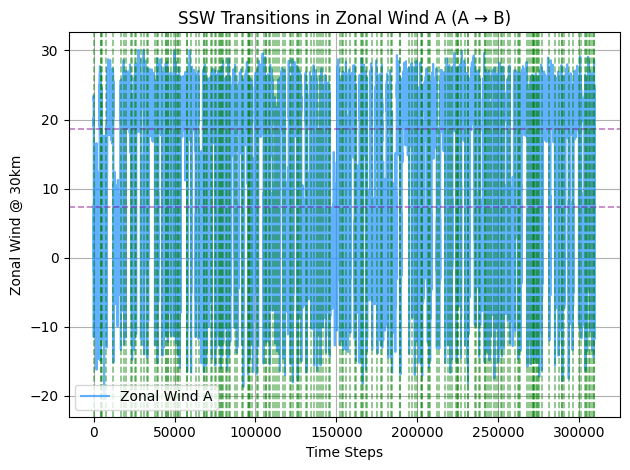

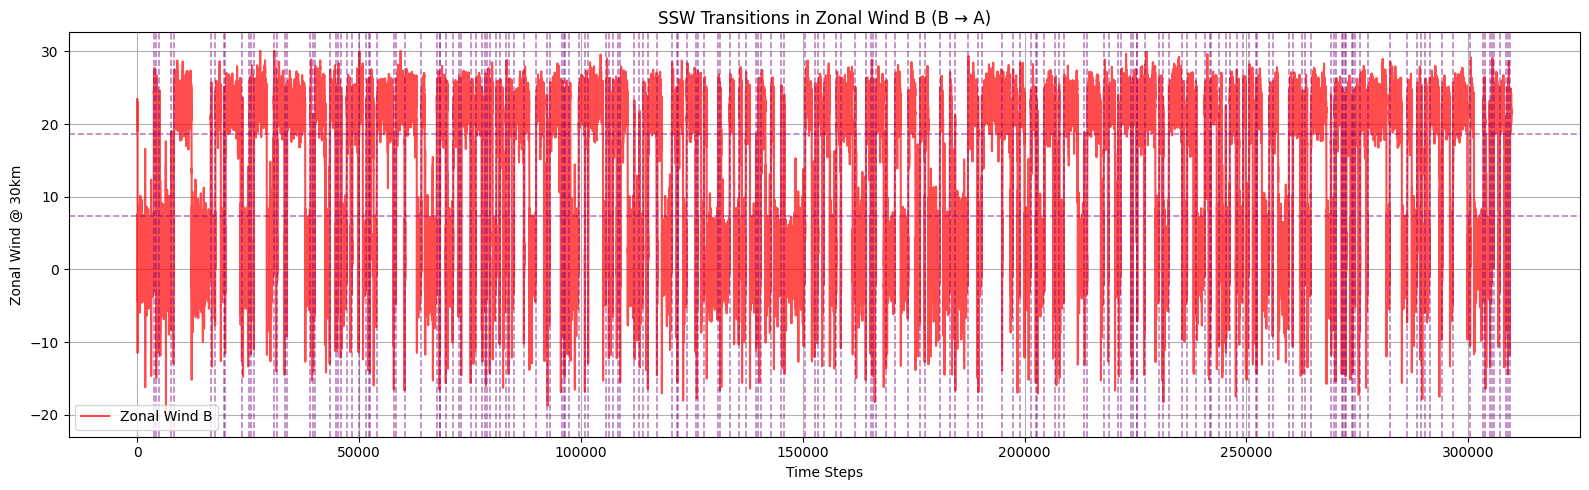

/tmp/ipykernel_50124/3422965528.py:260: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/tmp/ipykernel_50124/3422965528.py:268: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



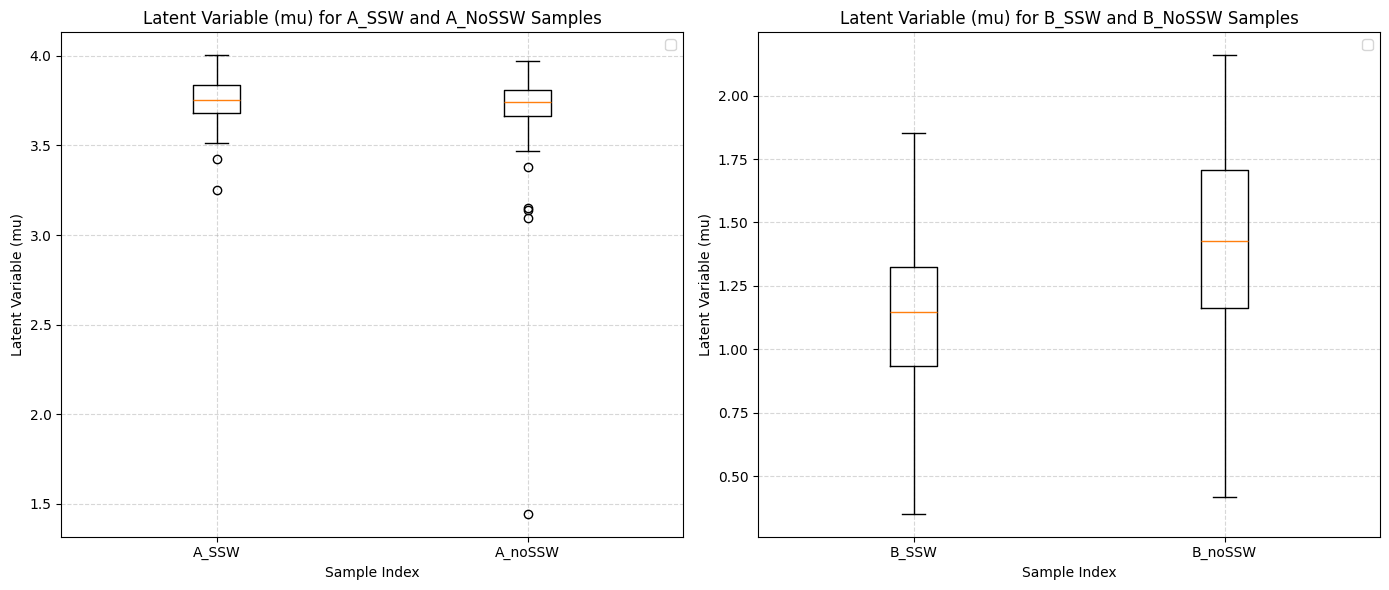

/tmp/ipykernel_50124/3422965528.py:282: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/tmp/ipykernel_50124/3422965528.py:290: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



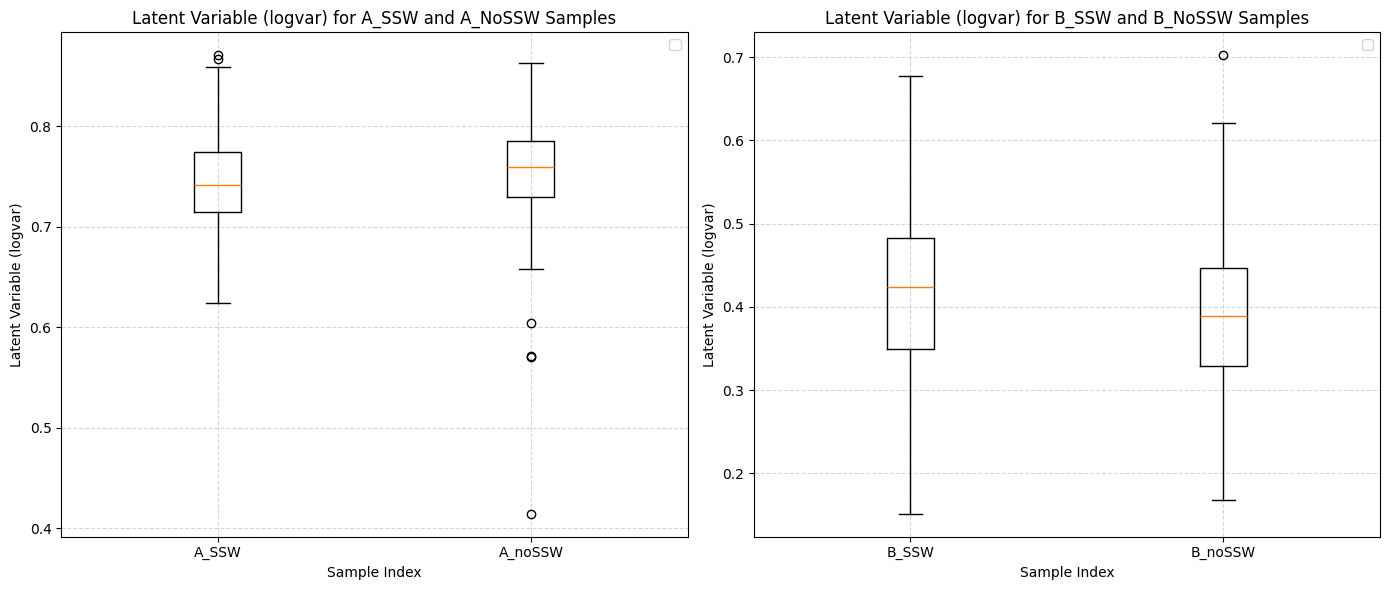

/tmp/ipykernel_50124/3422965528.py:304: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/tmp/ipykernel_50124/3422965528.py:312: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



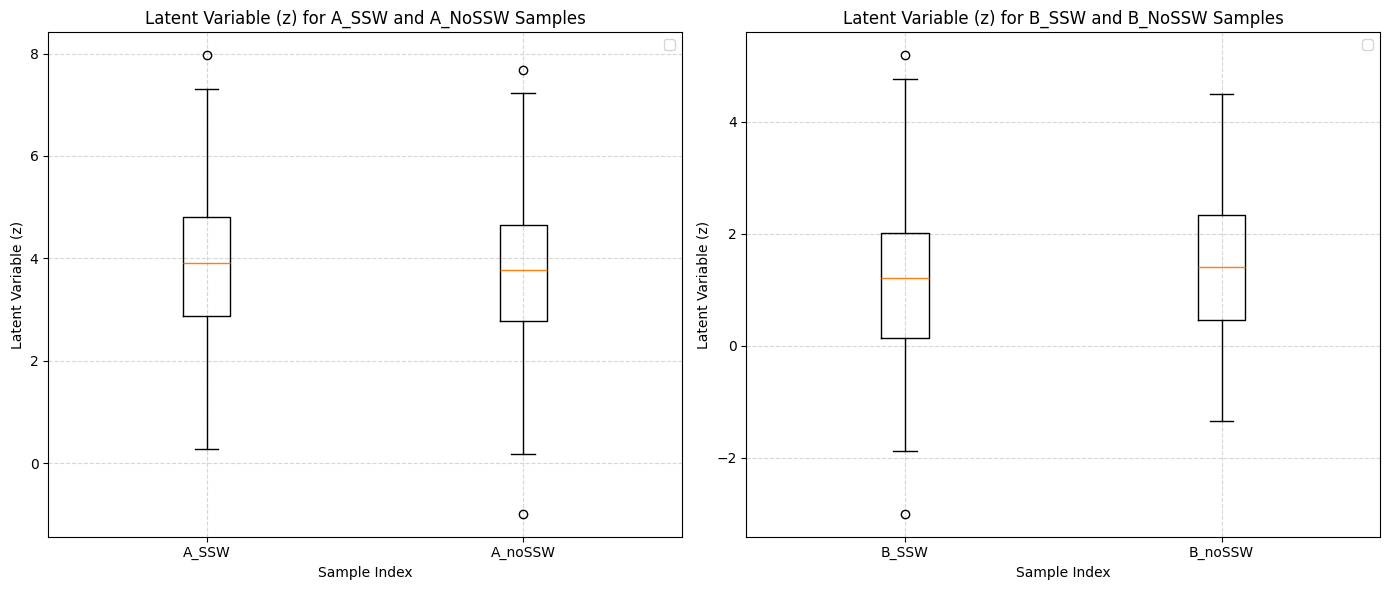

In [87]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd

# Load data
data = np.load("/home/danielboscu/Documents/code/AI_RES/data/actual/long_run_310k.npy")
zonal_wind = data[:, 0, 63]
upper, lower = 53.8 / 2.8935, 7.41

import seaborn as sns
from sklearn.metrics import mean_squared_error

# Initialization
time_step       = 300_000
real_data       = np.load(r'/home/danielboscu/Documents/code/AI_RES/data/actual/long_run_310k.npy')
level           = 63
upper_bound     = 53.8 / 2.8935
lower_bound     = 7.41
real_data_1d    = real_data[:, 1, level]

num_neurons     = 1024
latent_dim      = 32
output_dim      = 75
condition_dim   = num_variables

print(f"Number of neurons: {num_neurons}, Latent dimension: {latent_dim}, Output dimension: {output_dim}, Condition dimension: {condition_dim}")
model = ConditionalVAE(latent_dim, output_dim, condition_dim, num_neurons)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
start, end = variable_range[variable][0], variable_range[variable][1]+1
print(f"Variable range for {variable}: {start} to {end}")

folder = "/home/danielboscu/Documents/code/AI_RES/training"
model_weights_path = r'/home/danielboscu/Documents/code/AI_RES/training/best/checkpoint_11.pth'
past_model = True

if past_model:
    if os.path.exists(model_weights_path):
        model.load_state_dict(torch.load(model_weights_path))
        print(f"Model weights loaded from {model_weights_path}")

def detect_transitions_and_nontransitions_A_to_B(u_series, upper, lower):
    transitions = []
    transition_values = []
    non_transitions = []
    non_transition_values = []
    i = 0
    while i < len(u_series) - 1:
        if u_series[i] > upper:
            j = i + 1
            timer = 0
            while j < len(u_series) and u_series[j] < upper:
                timer += 1
                if u_series[j] < lower:
                    transitions.append(i)
                    transition_values.append(u_series[i])
                    timer = 0
                    break
                j += 1
            if timer >= 5:
                non_transitions.append(i)
                non_transition_values.append(u_series[i])
                timer = 0
            i = j
        else:
            i += 1
    return np.array(transitions), np.array(non_transitions), np.array(transition_values), np.array(non_transition_values)


def detect_transitions_and_nontransitionsB_to_A(u_series, upper, lower):
    transitions = []
    transition_values = []
    non_transitions = []
    non_transition_values = []
    i = 0
    while i < len(u_series) - 1:
        if u_series[i] < lower:
            j = i + 1
            timer = 0
            while j < len(u_series) and u_series[j] > lower:
                timer += 1
                if u_series[j] > upper:
                    transitions.append(i)
                    transition_values.append(u_series[i])
                    timer = 0
                    break
                j += 1
            if timer >= 5:
                non_transitions.append(i)
                non_transition_values.append(u_series[i])
                timer = 0
            i = j
        else:
            i += 1
    return np.array(transitions), np.array(non_transitions), np.array(transition_values), np.array(non_transition_values)

ssw_indices_A, non_ssw_indices_A, ssw_transition_values_A, non_ssw_transition_values_A = detect_transitions_and_nontransitions_A_to_B(zonal_wind, upper, lower)
ssw_indices_B, non_ssw_indices_B, ssw_transition_values_B, non_ssw_transition_values_B = detect_transitions_and_nontransitionsB_to_A(zonal_wind, upper, lower)

# transition_indices = np.union1d(ssw_indices_A, ssw_indices_B)
# total_len = len(data)
# non_ssw_sample_A = np.where((zonal_wind > upper) & (~np.isin(np.arange(total_len), transition_indices)))[0]

# non_ssw_sample_B = np.where((zonal_wind < lower) & (~np.isin(np.arange(total_len), transition_indices)))[0]

n_samples = min(len(ssw_indices_A), len(non_ssw_indices_A), len(non_ssw_indices_B))
non_ssw_indices_A = np.random.choice(non_ssw_indices_A, size=n_samples, replace=False)
non_ssw_indices_B = np.random.choice(non_ssw_indices_B, size=n_samples, replace=False)

print(f"SSW Transitions A to B: {len(ssw_indices_A)}, Mean Value: {np.mean(ssw_transition_values_A):.2f}")
print(f"SSW Transitions B to A: {len(ssw_indices_B)}, Mean Value: {np.mean(ssw_transition_values_B):.2f}")
print(f"Non-SSW Transitions A: {len(non_ssw_indices_A)}, Mean Value: {np.mean(non_ssw_transition_values_A):.2f}")
print(f"Non-SSW Transitions B: {len(non_ssw_indices_B)}, Mean Value: {np.mean(non_ssw_transition_values_B):.2f}")

X = np.vstack([
    data[ssw_indices_A, 0],
    data[non_ssw_indices_A, 0],
    data[ssw_indices_B, 0],
    data[non_ssw_indices_B, 0]
]).astype(np.float32)

labels = (
    ["A_SSW"] * len(ssw_indices_A) +
    ["A_noSSW"] * len(non_ssw_indices_A) +
    ["B_SSW"] * len(ssw_indices_B) +
    ["B_noSSW"] * len(non_ssw_indices_B)
)


model.eval()
# Encode data
with torch.no_grad():
    mu, logvar = model.encode(torch.tensor(X, dtype=torch.float32).cuda())
    z = model.reparameterize(mu, logvar)
    mu_np = mu.cpu().numpy()
    logvar_np = logvar.cpu().numpy()
    z_np = z.cpu().numpy()

print("Mu shape: " , mu.shape)
print("Mu values for A_ssw: ", np.mean(mu_np[:189, :]), "Mu values for B_ssw: ", np.mean(mu_np[189:379, :]), "Mu values for A_noSSW: ", np.mean(mu_np[379:569, :]), "Mu values for B_noSSW: ", np.mean(mu_np[569:, :]))
print("Logvar shape for A_ssw: ", np.mean(logvar_np[:189, :]), "Logvar shape for B_ssw: ", np.mean(logvar_np[189:379, :]), "Logvar shape for A_noSSW: ", np.mean(logvar_np[379:569, :]), "Logvar shape for B_noSSW: ", np.mean(logvar_np[569:, :]))
print("Z values for A_ssw: ", np.mean(z_np[:189, :]), "Z values for B_ssw: ", np.mean(z_np[189:379, :]), "Z values for A_noSSW: ", np.mean(z_np[379:569, :]), "Z values for B_noSSW: ", np.mean(z_np[569:, :]))

# PCA
num_components = 3
pca = PCA(n_components=num_components)
print(f"==>> pca: {pca}")

#mu
latent_3d = pca.fit_transform(mu_np)
print(f"==>> latent_3d: {latent_3d.shape}")


explained = pca.explained_variance_ratio_
total_explained = np.sum(explained)
print(f"Explained variance by PC1: {explained[0]:.4f}")
print(f"Explained variance by PC2: {explained[1]:.4f}")
print(f"Explained variance by PC3: {explained[2]:.4f}")
print(f"Total explained variance (PC1+2+3): {total_explained:.4f}")
# Build DataFrame
df = pd.DataFrame(latent_3d[:,num_components%3:num_components], columns=["PC1", "PC2", "PC3"] )
df["Category"] = labels

# Plot 3D PCA
fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", color="Category",
                    opacity=0.75,
                    title="Latent Space Projection: 4-Way Classification, mu",
                     width=1200, height=800)
fig.show()

#logvar
latent_3d = pca.fit_transform(logvar_np)
print(f"==>> latent_3d: {latent_3d.shape}")


explained = pca.explained_variance_ratio_
total_explained = np.sum(explained)
print(f"Explained variance by PC1: {explained[0]:.4f}")
print(f"Explained variance by PC2: {explained[1]:.4f}")
print(f"Explained variance by PC3: {explained[2]:.4f}")
print(f"Total explained variance (PC1+2+3): {total_explained:.4f}")
# Build DataFrame
df = pd.DataFrame(latent_3d[:,num_components%3:num_components], columns=["PC1", "PC2", "PC3"] )
df["Category"] = labels

# Plot 3D PCA
fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", color="Category",
                    opacity=0.75,
                    title="Latent Space Projection: 4-Way Classification, logvar",
                     width=1200, height=800)
fig.show()

#z
latent_3d = pca.fit_transform(z_np)
print(f"==>> latent_3d: {latent_3d.shape}")


explained = pca.explained_variance_ratio_
total_explained = np.sum(explained)
print(f"Explained variance by PC1: {explained[0]:.4f}")
print(f"Explained variance by PC2: {explained[1]:.4f}")
print(f"Explained variance by PC3: {explained[2]:.4f}")
print(f"Total explained variance (PC1+2+3): {total_explained:.4f}")
# Build DataFrame
df = pd.DataFrame(latent_3d[:,num_components%3:num_components], columns=["PC1", "PC2", "PC3"] )
df["Category"] = labels

# Plot 3D PCA
fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", color="Category",
                    opacity=0.75,
                    title="Latent Space Projection: 4-Way Classification, z",
                     width=1200, height=800)
fig.show()

# latent plots
plt.plot(data[:, 0, 63], label="Zonal Wind A", color='dodgerblue', alpha=0.7)
plt.axhline(y=lower_bound, color='purple', linestyle='--', alpha=0.5, linewidth=1.2)
plt.axhline(y=upper_bound, color='purple', linestyle='--', alpha=0.5, linewidth=1.2)

for idx in ssw_indices_A:
    plt.axvline(x=idx, color='green', linestyle='--', alpha=0.5, linewidth=1.2)

plt.xlabel("Time Steps")
plt.ylabel("Zonal Wind @ 30km")
plt.title("SSW Transitions in Zonal Wind A (A → B)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(data[:, 0, 63], label="Zonal Wind B", color='red', alpha=0.7)

for idx in ssw_indices_B:
    plt.axvline(x=idx, color='purple', linestyle='--', alpha=0.5, linewidth=1.2)
plt.axhline(y=lower_bound, color='purple', linestyle='--', alpha=0.5, linewidth=1.2)
plt.axhline(y=upper_bound, color='purple', linestyle='--', alpha=0.5, linewidth=1.2)

plt.xlabel("Time Steps")
plt.ylabel("Zonal Wind @ 30km")
plt.title("SSW Transitions in Zonal Wind B (B → A)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(1, 2, figure=fig)
ax_1 = fig.add_subplot(gs[0, 0])
ax_1.boxplot([mu_np[:189, 0], mu_np[189:379, 0]],
            tick_labels=["A_SSW", "A_noSSW"])
ax_1.grid(True, linestyle='--', alpha=0.5)
ax_1.set_xlabel("Sample Index")
ax_1.set_ylabel("Latent Variable (mu)")
ax_1.set_title("Latent Variable (mu) for A_SSW and A_NoSSW Samples")
ax_1.legend()
ax_2 = fig.add_subplot(gs[0, 1])
ax_2.boxplot([mu_np[380:569, 0], mu_np[569:, 0]],
            tick_labels=["B_SSW", "B_noSSW"])
ax_2.grid(True, linestyle='--', alpha=0.5)
ax_2.set_xlabel("Sample Index")
ax_2.set_ylabel("Latent Variable (mu)")
ax_2.set_title("Latent Variable (mu) for B_SSW and B_NoSSW Samples")
ax_2.legend()

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(1, 2, figure=fig)
ax_1 = fig.add_subplot(gs[0, 0])
ax_1.boxplot([logvar_np[:189, 0], logvar_np[189:379, 0]],
            tick_labels=["A_SSW", "A_noSSW"])
ax_1.grid(True, linestyle='--', alpha=0.5)
ax_1.set_xlabel("Sample Index")
ax_1.set_ylabel("Latent Variable (logvar)")
ax_1.set_title("Latent Variable (logvar) for A_SSW and A_NoSSW Samples")
ax_1.legend()
ax_2 = fig.add_subplot(gs[0, 1])
ax_2.boxplot([logvar_np[380:569, 0], logvar_np[569:, 0]],
            tick_labels=["B_SSW", "B_noSSW"])
ax_2.grid(True, linestyle='--', alpha=0.5)
ax_2.set_xlabel("Sample Index")
ax_2.set_ylabel("Latent Variable (logvar)")
ax_2.set_title("Latent Variable (logvar) for B_SSW and B_NoSSW Samples")
ax_2.legend()

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(1, 2, figure=fig)
ax_1 = fig.add_subplot(gs[0, 0])
ax_1.boxplot([z_np[:189, 0], z_np[189:379, 0]],
            tick_labels=["A_SSW", "A_noSSW"])
ax_1.grid(True, linestyle='--', alpha=0.5)
ax_1.set_xlabel("Sample Index")
ax_1.set_ylabel("Latent Variable (z)")
ax_1.set_title("Latent Variable (z) for A_SSW and A_NoSSW Samples")
ax_1.legend()
ax_2 = fig.add_subplot(gs[0, 1])
ax_2.boxplot([z_np[380:569, 0], z_np[569:, 0]],
            tick_labels=["B_SSW", "B_noSSW"])
ax_2.grid(True, linestyle='--', alpha=0.5)
ax_2.set_xlabel("Sample Index")
ax_2.set_ylabel("Latent Variable (z)")
ax_2.set_title("Latent Variable (z) for B_SSW and B_NoSSW Samples")
ax_2.legend()

plt.tight_layout()
plt.show()

## In-State VS Transitioning points

SSW Transitions A to B: 189, Mean Value: 18.93
SSW Transitions B to A: 189, Mean Value: 6.89
Non-SSW Transitions A: 189, Mean Value: 22.98
Non-SSW Transitions B: 189, Mean Value: 1.55
Mu shape:  torch.Size([756, 32])
Mu values for A_ssw:  0.027109237 Mu values for B_ssw:  0.013175129 Mu values for A_noSSW:  0.0017724925 Mu values for B_noSSW:  0.001349827
Logvar shape for A_ssw:  -1.6799983 Logvar shape for B_ssw:  -1.8161747 Logvar shape for A_noSSW:  -0.57603866 Logvar shape for B_noSSW:  -0.5371615
Z values for A_ssw:  0.042001985 Z values for B_ssw:  0.02877942 Z values for A_noSSW:  0.012141149 Z values for B_noSSW:  0.008527474
==>> pca: PCA(n_components=3)
==>> latent_3d: (756, 3)
Explained variance by PC1: 0.9959
Explained variance by PC2: 0.0017
Explained variance by PC3: 0.0010
Total explained variance (PC1+2+3): 0.9986


==>> latent_3d: (756, 3)
Explained variance by PC1: 0.9979
Explained variance by PC2: 0.0009
Explained variance by PC3: 0.0005
Total explained variance (PC1+2+3): 0.9993


==>> latent_3d: (756, 3)
Explained variance by PC1: 0.5581
Explained variance by PC2: 0.1701
Explained variance by PC3: 0.1040
Total explained variance (PC1+2+3): 0.8322


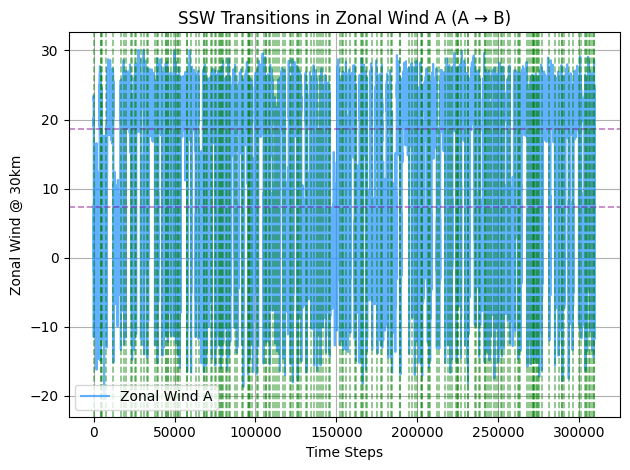

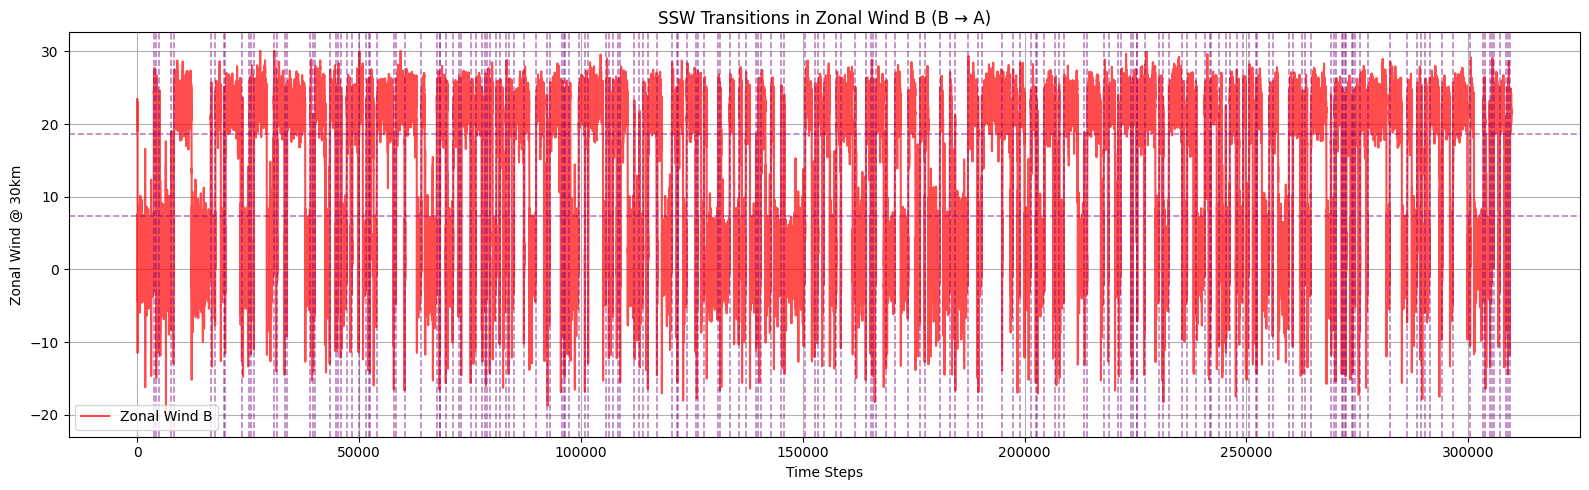

/tmp/ipykernel_50124/3897926090.py:199: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/tmp/ipykernel_50124/3897926090.py:207: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



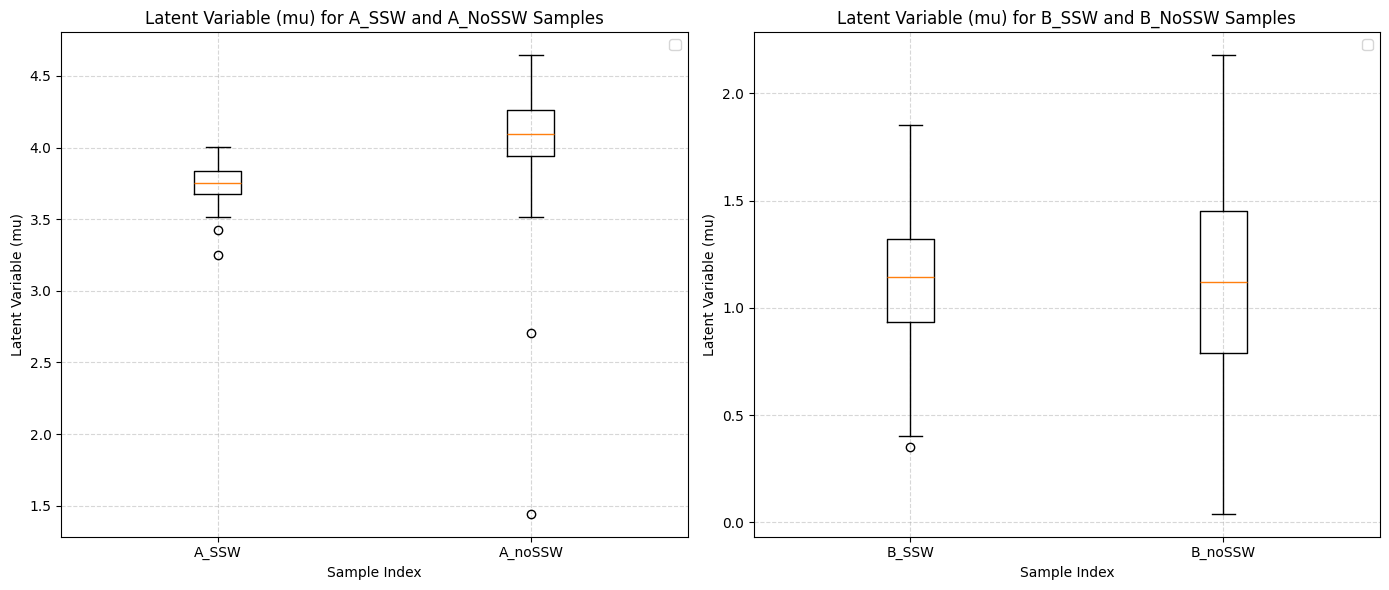

/tmp/ipykernel_50124/3897926090.py:221: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/tmp/ipykernel_50124/3897926090.py:229: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



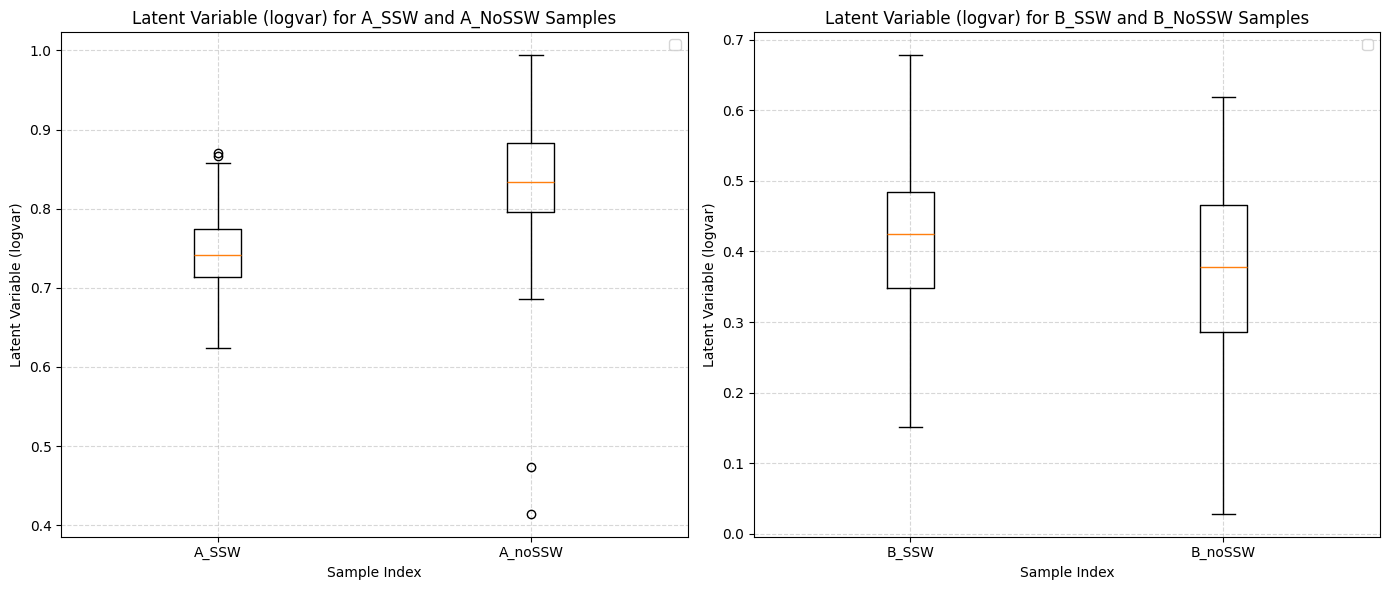

/tmp/ipykernel_50124/3897926090.py:243: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/tmp/ipykernel_50124/3897926090.py:251: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



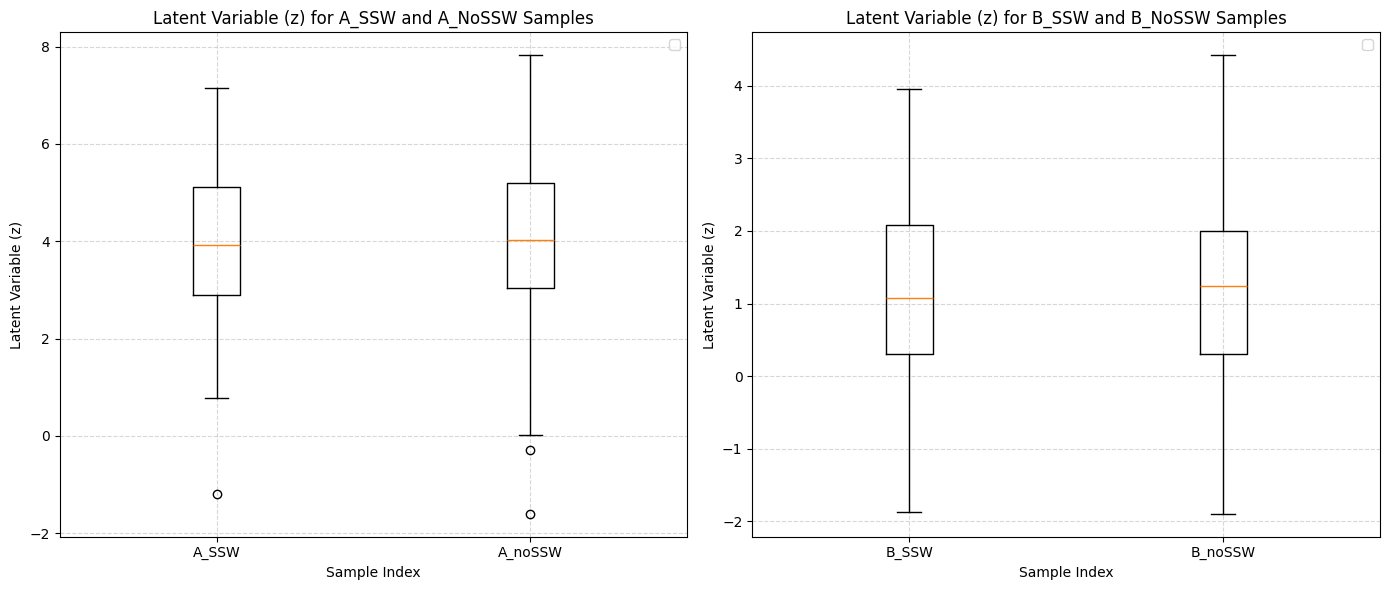

In [88]:
def detect_transitions_A_to_B(u_series, upper, lower):
    transitions = []
    transition_values = []
    i = 0
    while i < len(u_series) - 1:
        if u_series[i] > upper:
            j = i + 1
            while j < len(u_series) and u_series[j] < upper:
                if u_series[j] < lower:
                    transitions.append(i)
                    transition_values.append(u_series[i])
                    break
                j += 1
            i = j
        else:
            i += 1
    return np.array(transitions), np.array(transition_values)


def detect_transitions_B_to_A(u_series, upper, lower):
    transitions = []
    transition_values = []
    i = 0
    while i < len(u_series) - 1:
        if u_series[i] < lower:
            j = i + 1
            while j < len(u_series) and u_series[j] > lower:
                if u_series[j] > upper:
                    transitions.append(i)
                    transition_values.append(u_series[i])
                    break
                j += 1
            i = j
        else:
            i += 1
    return np.array(transitions), np.array(transition_values)

ssw_indices_A, ssw_transition_values_A = detect_transitions_A_to_B(zonal_wind, upper, lower)
ssw_indices_B, ssw_transition_values_B = detect_transitions_B_to_A(zonal_wind, upper, lower)

transition_indices = np.union1d(ssw_indices_A, ssw_indices_B)
total_len = len(data)
non_ssw_indices_A = np.where((zonal_wind > upper) & (~np.isin(np.arange(total_len), transition_indices)))[0]
non_ssw_indices_B = np.where((zonal_wind < lower) & (~np.isin(np.arange(total_len), transition_indices)))[0]

n_samples = min(len(ssw_indices_A), len(non_ssw_indices_A), len(non_ssw_indices_B))
non_ssw_indices_A = np.random.choice(non_ssw_indices_A, size=n_samples, replace=False)
non_ssw_indices_B = np.random.choice(non_ssw_indices_B, size=n_samples, replace=False)
non_ssw_transition_values_A = zonal_wind[non_ssw_indices_A]
non_ssw_transition_values_B = zonal_wind[non_ssw_indices_B]

print(f"SSW Transitions A to B: {len(ssw_indices_A)}, Mean Value: {np.mean(ssw_transition_values_A):.2f}")
print(f"SSW Transitions B to A: {len(ssw_indices_B)}, Mean Value: {np.mean(ssw_transition_values_B):.2f}")
print(f"Non-SSW Transitions A: {len(non_ssw_indices_A)}, Mean Value: {np.mean(non_ssw_transition_values_A):.2f}")
print(f"Non-SSW Transitions B: {len(non_ssw_indices_B)}, Mean Value: {np.mean(non_ssw_transition_values_B):.2f}")

X = np.vstack([
    data[ssw_indices_A, 0],
    data[non_ssw_indices_A, 0],
    data[ssw_indices_B, 0],
    data[non_ssw_indices_B, 0]
]).astype(np.float32)

labels = (
    ["A_SSW"] * len(ssw_indices_A) +
    ["A_noSSW"] * len(non_ssw_indices_A) +
    ["B_SSW"] * len(ssw_indices_B) +
    ["B_noSSW"] * len(non_ssw_indices_B)
)


model.eval()
# Encode data
with torch.no_grad():
    mu, logvar = model.encode(torch.tensor(X, dtype=torch.float32).cuda())
    z = model.reparameterize(mu, logvar)
    mu_np = mu.cpu().numpy()
    logvar_np = logvar.cpu().numpy()
    z_np = z.cpu().numpy()

print("Mu shape: " , mu.shape)
print("Mu values for A_ssw: ", np.mean(mu_np[:189, :]), "Mu values for B_ssw: ", np.mean(mu_np[189:379, :]), "Mu values for A_noSSW: ", np.mean(mu_np[379:569, :]), "Mu values for B_noSSW: ", np.mean(mu_np[569:, :]))
print("Logvar shape for A_ssw: ", np.mean(logvar_np[:189, :]), "Logvar shape for B_ssw: ", np.mean(logvar_np[189:379, :]), "Logvar shape for A_noSSW: ", np.mean(logvar_np[379:569, :]), "Logvar shape for B_noSSW: ", np.mean(logvar_np[569:, :]))
print("Z values for A_ssw: ", np.mean(z_np[:189, :]), "Z values for B_ssw: ", np.mean(z_np[189:379, :]), "Z values for A_noSSW: ", np.mean(z_np[379:569, :]), "Z values for B_noSSW: ", np.mean(z_np[569:, :]))

# PCA
num_components = 3
pca = PCA(n_components=num_components)
print(f"==>> pca: {pca}")

#mu
latent_3d = pca.fit_transform(mu_np)
print(f"==>> latent_3d: {latent_3d.shape}")


explained = pca.explained_variance_ratio_
total_explained = np.sum(explained)
print(f"Explained variance by PC1: {explained[0]:.4f}")
print(f"Explained variance by PC2: {explained[1]:.4f}")
print(f"Explained variance by PC3: {explained[2]:.4f}")
print(f"Total explained variance (PC1+2+3): {total_explained:.4f}")
# Build DataFrame
df = pd.DataFrame(latent_3d[:,num_components%3:num_components], columns=["PC1", "PC2", "PC3"] )
df["Category"] = labels

# Plot 3D PCA
fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", color="Category",
                    opacity=0.75,
                    title="Latent Space Projection: 4-Way Classification, mu",
                     width=1200, height=800)
fig.show()

#logvar
latent_3d = pca.fit_transform(logvar_np)
print(f"==>> latent_3d: {latent_3d.shape}")


explained = pca.explained_variance_ratio_
total_explained = np.sum(explained)
print(f"Explained variance by PC1: {explained[0]:.4f}")
print(f"Explained variance by PC2: {explained[1]:.4f}")
print(f"Explained variance by PC3: {explained[2]:.4f}")
print(f"Total explained variance (PC1+2+3): {total_explained:.4f}")
# Build DataFrame
df = pd.DataFrame(latent_3d[:,num_components%3:num_components], columns=["PC1", "PC2", "PC3"] )
df["Category"] = labels

# Plot 3D PCA
fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", color="Category",
                    opacity=0.75,
                    title="Latent Space Projection: 4-Way Classification, logvar",
                     width=1200, height=800)
fig.show()

#z
latent_3d = pca.fit_transform(z_np)
print(f"==>> latent_3d: {latent_3d.shape}")


explained = pca.explained_variance_ratio_
total_explained = np.sum(explained)
print(f"Explained variance by PC1: {explained[0]:.4f}")
print(f"Explained variance by PC2: {explained[1]:.4f}")
print(f"Explained variance by PC3: {explained[2]:.4f}")
print(f"Total explained variance (PC1+2+3): {total_explained:.4f}")
# Build DataFrame
df = pd.DataFrame(latent_3d[:,num_components%3:num_components], columns=["PC1", "PC2", "PC3"] )
df["Category"] = labels

# Plot 3D PCA
fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", color="Category",
                    opacity=0.75,
                    title="Latent Space Projection: 4-Way Classification, z",
                     width=1200, height=800)
fig.show()

# latent plots
plt.plot(data[:, 0, 63], label="Zonal Wind A", color='dodgerblue', alpha=0.7)
plt.axhline(y=lower_bound, color='purple', linestyle='--', alpha=0.5, linewidth=1.2)
plt.axhline(y=upper_bound, color='purple', linestyle='--', alpha=0.5, linewidth=1.2)

for idx in ssw_indices_A:
    plt.axvline(x=idx, color='green', linestyle='--', alpha=0.5, linewidth=1.2)

plt.xlabel("Time Steps")
plt.ylabel("Zonal Wind @ 30km")
plt.title("SSW Transitions in Zonal Wind A (A → B)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(data[:, 0, 63], label="Zonal Wind B", color='red', alpha=0.7)

for idx in ssw_indices_B:
    plt.axvline(x=idx, color='purple', linestyle='--', alpha=0.5, linewidth=1.2)
plt.axhline(y=lower_bound, color='purple', linestyle='--', alpha=0.5, linewidth=1.2)
plt.axhline(y=upper_bound, color='purple', linestyle='--', alpha=0.5, linewidth=1.2)

plt.xlabel("Time Steps")
plt.ylabel("Zonal Wind @ 30km")
plt.title("SSW Transitions in Zonal Wind B (B → A)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(1, 2, figure=fig)
ax_1 = fig.add_subplot(gs[0, 0])
ax_1.boxplot([mu_np[:189, 0], mu_np[189:379, 0]],
            tick_labels=["A_SSW", "A_noSSW"])
ax_1.grid(True, linestyle='--', alpha=0.5)
ax_1.set_xlabel("Sample Index")
ax_1.set_ylabel("Latent Variable (mu)")
ax_1.set_title("Latent Variable (mu) for A_SSW and A_NoSSW Samples")
ax_1.legend()
ax_2 = fig.add_subplot(gs[0, 1])
ax_2.boxplot([mu_np[380:569, 0], mu_np[569:, 0]],
            tick_labels=["B_SSW", "B_noSSW"])
ax_2.grid(True, linestyle='--', alpha=0.5)
ax_2.set_xlabel("Sample Index")
ax_2.set_ylabel("Latent Variable (mu)")
ax_2.set_title("Latent Variable (mu) for B_SSW and B_NoSSW Samples")
ax_2.legend()

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(1, 2, figure=fig)
ax_1 = fig.add_subplot(gs[0, 0])
ax_1.boxplot([logvar_np[:189, 0], logvar_np[189:379, 0]],
            tick_labels=["A_SSW", "A_noSSW"])
ax_1.grid(True, linestyle='--', alpha=0.5)
ax_1.set_xlabel("Sample Index")
ax_1.set_ylabel("Latent Variable (logvar)")
ax_1.set_title("Latent Variable (logvar) for A_SSW and A_NoSSW Samples")
ax_1.legend()
ax_2 = fig.add_subplot(gs[0, 1])
ax_2.boxplot([logvar_np[380:569, 0], logvar_np[569:, 0]],
            tick_labels=["B_SSW", "B_noSSW"])
ax_2.grid(True, linestyle='--', alpha=0.5)
ax_2.set_xlabel("Sample Index")
ax_2.set_ylabel("Latent Variable (logvar)")
ax_2.set_title("Latent Variable (logvar) for B_SSW and B_NoSSW Samples")
ax_2.legend()

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(1, 2, figure=fig)
ax_1 = fig.add_subplot(gs[0, 0])
ax_1.boxplot([z_np[:189, 0], z_np[189:379, 0]],
            tick_labels=["A_SSW", "A_noSSW"])
ax_1.grid(True, linestyle='--', alpha=0.5)
ax_1.set_xlabel("Sample Index")
ax_1.set_ylabel("Latent Variable (z)")
ax_1.set_title("Latent Variable (z) for A_SSW and A_NoSSW Samples")
ax_1.legend()
ax_2 = fig.add_subplot(gs[0, 1])
ax_2.boxplot([z_np[380:569, 0], z_np[569:, 0]],
            tick_labels=["B_SSW", "B_noSSW"])
ax_2.grid(True, linestyle='--', alpha=0.5)
ax_2.set_xlabel("Sample Index")
ax_2.set_ylabel("Latent Variable (z)")
ax_2.set_title("Latent Variable (z) for B_SSW and B_NoSSW Samples")
ax_2.legend()

plt.tight_layout()
plt.show()

# Attempting to Visualize the State Space of the Model

In [84]:
import numpy as np
import torch
import plotly.express as px
import pandas as pd
model.eval()

# Feature indices to visualize
feature_indices = [14, 38, 64]
num_examples = 25

records = []

index = 45_343
for t in range(num_examples):
    initial_cond_raw = psi[index, :]
    true_next_state = psi[index + 1, :]
    index += 1

    # Normalize initial condition
    initial_cond_norm = (initial_cond_raw - mean_psi[:, 0]) / std_psi[:, 0]
    initial_cond_norm = initial_cond_norm[:50]
    initial_cond_tensor = torch.tensor(initial_cond_norm, dtype=torch.float32, device=device).view(1, -1)

    # Predict next state
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device)
        pred_norm = model.decode(z, initial_cond_tensor)
        pred_norm = pred_norm.squeeze().cpu().numpy()
        pred_denorm = pred_norm * std_psi[:, 0] + mean_psi[:, 0]

    #denormalize the ground truth
    true_next_denorm = true_next_state * std_psi[:, 0] + mean_psi[:, 0]
    initial_cond_denorm = initial_cond_raw

    #Extract feature triplets
    ic_feats = initial_cond_denorm[feature_indices]
    pred_feats = pred_denorm[feature_indices]
    true_feats = true_next_denorm[feature_indices]

    # Add to records
    records.append({"Trajectory": f"Traj {t}", "label": "Initial Condition", "x": ic_feats[0], "y": ic_feats[1], "z": ic_feats[2]})
    records.append({"Trajectory": f"Traj {t}", "label": "Prediction", "x": pred_feats[0], "y": pred_feats[1], "z": pred_feats[2]})
    records.append({"Trajectory": f"Traj {t}", "label": "Ground Truth", "x": true_feats[0], "y": true_feats[1], "z": true_feats[2]})

# DataFrame for plotting
df = pd.DataFrame(records)

# Plot with Plotly
fig = px.scatter_3d(
    df, x="x", y="y", z="z", color="label", symbol="label",
    title="Initial → Prediction vs Ground Truth (3D Feature Space)",
    width=1400, height=600
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(scene=dict(
    xaxis_title=f"Feature {feature_indices[0]}",
    yaxis_title=f"Feature {feature_indices[1]}",
    zaxis_title=f"Feature {feature_indices[2]}"
))
fig.show()